# Train a deep CNN on XPS data on Google Colab

In this notebook, we will train a deep convolutional network on XPS spectra made up of linear combinations of reference spectra.

## Setup

### Mount google drive, change working directory

In [1]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Change working path
os.chdir('/content/drive/My Drive/deepxps')

Mounted at /content/drive


### Install packages and import modules

In [2]:
%%capture
# Install packages
!pip install python-docx

# Import standard modules and magic commands
import datetime
import numpy as np
import pytz
import importlib

# Magic commands
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Install and import TensorFlow

In [3]:
# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import tensorflow as tf

### Set seeds and restart session to ensure reproducibility

In [4]:
def reset_seeds_and_session(seed=1):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)

   session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                           inter_op_parallelism_threads=1)
   sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),
                               config=session_conf)
   tf.compat.v1.keras.backend.set_session(sess) 

reset_seeds_and_session(seed=1)

### Check TensorFlow version

In [5]:
f"TF version: {tf.__version__}."

'TF version: 2.9.2.'

### Check hardware connection

In [6]:
from tensorflow.python.profiler import profiler_client

if tf.test.gpu_device_name():
    print(f"Found GPU: {tf.test.gpu_device_name()}.")
    !nvidia-smi
else:
    print("Found no GPU.")
try:
    tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
    print(f"Found TPU: {profiler_client.monitor(tpu_profile_service_address, 100, 2)}.")
except:
    print("Found no TPU.")

Found GPU: /device:GPU:0.
Mon Nov  7 08:31:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |    312MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

## Initial training

### Load custom modules

In [7]:
try:
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('Modules were loaded.')

Modules were loaded.


### Set up the parameters & folder structure



In [8]:
time = datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
exp_name = "Co_linear_combination_normalized_inputs_small_gas_phase_shortened"

clf = classifier.Classifier(time = time,
                            exp_name = exp_name,
                            task = "regression",
                            intensity_only = True)

### If labels not saved with data ###
# =============================================================================
# labels = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']
# clf = classifier.Classifier(time = time,
#                            exp_name = exp_name,
#                            task = 'regression',
#                            intensity_only = True,
#                            labels = labels)
# =============================================================================

Model folder created at /20221107_09h31m_Co_linear_combination_normalized_inputs_small_gas_phase_shortened/model
Logs folder created at /20221107_09h31m_Co_linear_combination_normalized_inputs_small_gas_phase_shortened/logs
Figures folder created at /20221107_09h31m_Co_linear_combination_normalized_inputs_small_gas_phase_shortened/figures


### Load and inspect the data

Data was loaded!
Total no. of samples: 200000
No. of training samples: 128000
No. of validation samples: 32000
No. of test samples: 40000
Shape of each sample : 451 features (X) + 3 labels (y)


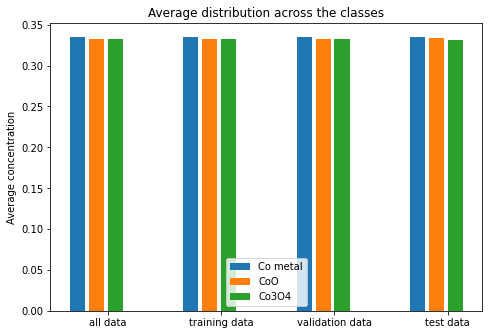

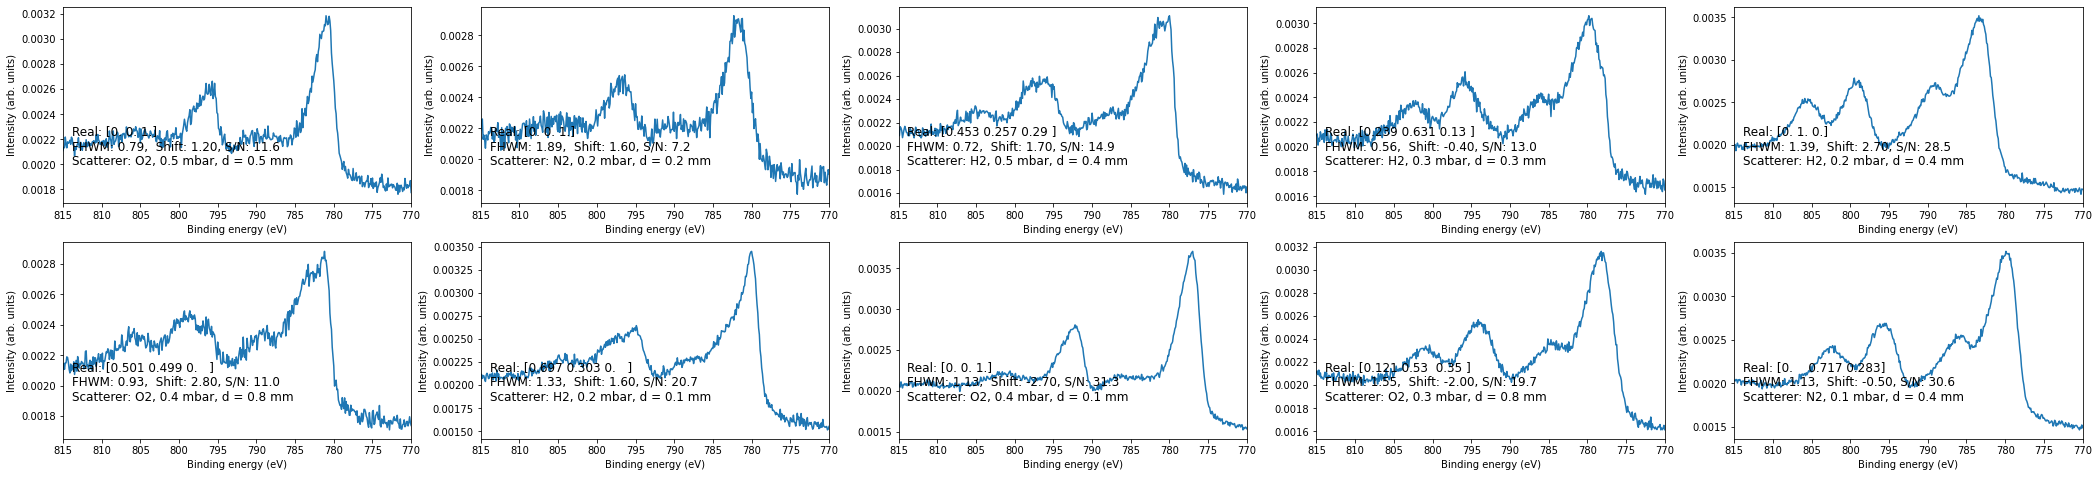

In [ ]:
input_filepath = r'/content/drive/My Drive/deepxps/datasets/20221102_Co_linear_combination_small_gas_phase_shortened.h5'

train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 200000

X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        clf.load_data_preprocess(input_filepath = input_filepath,
                                 no_of_examples = no_of_examples,
                                 train_test_split = train_test_split,
                                 train_val_split = train_val_split)
               
# Check how the examples are distributed across the classes.
class_distribution = clf.datahandler.check_class_distribution(clf.task)
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'train')  

### Design the model

In [ ]:
try:
    importlib.reload(models)
    print('Models module was reloaded.')
except:
    import xpsdeeplearning.network.models as models
    print('Models module was loaded.')

Models module was loaded.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.python.keras import backend as K

class CNN(models.EmptyModel):
    """
    A CNN with three convolutional layers of different kernel size at 
    the beginning. Works well for learning across scales.
    
    """
    def __init__(
        self, 
        inputshape,
        num_classes,
        task,
        ):   
        if len(inputshape) == 2:
            conv_layer = layers.Conv1D
            strides = 1
            average_pool_layer = layers.AveragePooling1D
        elif len(inputshape) == 3:
            conv_layer = layers.Conv2D
            strides = (1,1)
            average_pool_layer =  layers.AveragePooling2D

        if (task == "regression" or task == "multi_class_detection"):
            if num_classes == 1:
                output_act = None
            else:
                output_act = "sigmoid"
    
        elif task == "classification":
            output_act = "softmax"
        
        self.input_1 = layers.Input(
            shape = inputshape,
            name="input_1")
        self.conv_1_short = conv_layer(
            filters=12,
            kernel_size=5,
            strides=strides,
            padding='same',
            activation='relu',
            name='conv_1_short')(self.input_1)
        self.conv_1_medium = conv_layer(
            filters=12,
            kernel_size=10,
            strides=strides,
            padding='same',
            activation='relu',
            name='conv_1_medium')(self.input_1)
        self.conv_1_long = conv_layer(
            filters=12,
            kernel_size=15,
            strides=strides,
            padding='same',
            activation='relu',
            name='conv_1_long')(self.input_1)
        
        sublayers = [self.conv_1_short, self.conv_1_medium, self.conv_1_long]
        merged_sublayers = layers.concatenate(sublayers)

        self.conv_2 = conv_layer(
            filters=10,
            kernel_size=5,
            strides=strides,
            padding='valid',
            activation='relu',
            name='conv_2')(merged_sublayers)
        self.conv_3 = conv_layer(
            filters=10,
            kernel_size=5,
            strides=strides,
            padding='valid',
            activation='relu',
            name="conv_3")(self.conv_2)
        self.average_pool_1 = average_pool_layer(
            name='average_pool_1')(self.conv_3)
        self.flatten_1 = layers.Flatten(
            name='flatten1')(self.average_pool_1)
        self.drop_1 = layers.Dropout(
            rate=0.2,
            name='drop_1')(self.flatten_1)
        self.dense_1 = layers.Dense(
            units=4000,
            activation='relu',
            name='dense_1')(self.flatten_1)    
        self.dense_2 = layers.Dense(
            units=num_classes,
            activation=output_act,
            name='dense_2')(self.dense_1)
              
        if task == "regression":
            self.outputs = layers.Lambda(
                lambda x: x/tf.reshape(K.sum(x, axis=-1),(-1,1)),
                name = 'output_normalization')(self.dense_2)
        
        else:
            self.outputs = self.dense_2

        no_of_inputs = len(sublayers)

        super(CNN, self).__init__(
            inputs=self.input_1,
            outputs=self.outputs,
            inputshape=inputshape,
            num_classes=num_classes,
            no_of_inputs=no_of_inputs,
            name='CNN')

#### Build the model

In [ ]:
clf.model = CNN(clf.datahandler.input_shape,
                clf.datahandler.num_classes,
                task=clf.task)

# =============================================================================
# clf.model = ResNet1D(clf.datahandler.input_shape,
#                      clf.datahandler.num_classess,
#                      ap=True)
# =============================================================================

# Alternative: Build model from available models in models.py
# =============================================================================
# clf.model = models.RegressionCNN(clf.datahandler.input_shape, 
#                                  clf.datahandler.num_classes)
# =============================================================================
# =============================================================================
# clf.model = models.ResNet1D(clf.datahandler.input_shape,
#                             clf.datahandler.num_classes,
#                             ap=True)
# =============================================================================
# =============================================================================
# clf.model = models.ResNet1D(clf.datahandler.input_shape,
#                             clf.datahandler.num_classes,
#                             ap=True)
# =============================================================================

### Compile and summarize the model

Model: "CNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 451, 1)]     0           []                               
                                                                                                  
 conv_1_short (Conv1D)          (None, 451, 12)      72          ['input_1[0][0]']                
                                                                                                  
 conv_1_medium (Conv1D)         (None, 451, 12)      132         ['input_1[0][0]']                
                                                                                                  
 conv_1_long (Conv1D)           (None, 451, 12)      192         ['input_1[0][0]']                
                                                                                                

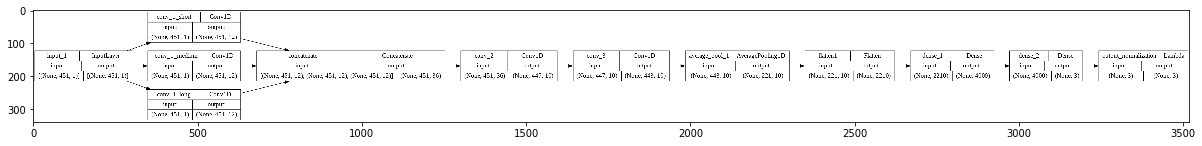

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import MeanSquaredError, CategoricalCrossentropy, BinaryAccuracy
    

learning_rate = 1e-05 #3e-04
optimizer = Adam(learning_rate = learning_rate) 

if clf.task == "regression":
    loss = MeanAbsoluteError()
    #loss = MeanSquaredError()
    metrics=[MeanSquaredError(name="mse")]
    
elif clf.task == "classification":
    loss = CategoricalCrossentropy()
    metrics = [CategoricalCrossentropy(name="accuracy")]
    
elif clf.task == "multi_class_detection":
    loss = BinaryCrossentropy()
    metrics = metrics = [BinaryAccuracy(name="accuracy")]
    
clf.model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)

# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Show initial predictions

In [ ]:
pred_train_initial, pred_test_initial = clf.predict()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(clf.datahandler.y_train[i],3)),
          'pred: ' + str(pred_train_initial[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(clf.datahandler.y_test[i],3)),
          'pred: ' + str(pred_test_initial[i]))

1250/1250 [==============================] - 3s 2ms/step
Prediction done!
Train:
real: [0.248 0.    0.752] pred: [0.33332375 0.33332705 0.33334917]
real: [0.    0.167 0.833] pred: [0.33331966 0.3333305  0.33334982]
real: [0. 1. 0.] pred: [0.33333084 0.3333236  0.3333455 ]
real: [1. 0. 0.] pred: [0.33332506 0.33332872 0.33334622]
real: [0.573 0.427 0.   ] pred: [0.33332214 0.3333284  0.33334944]
Test:
real: [0.606 0.    0.394] pred: [0.33332354 0.33332562 0.33335087]
real: [0.417 0.    0.583] pred: [0.33333007 0.33332697 0.3333429 ]
real: [0.223 0.224 0.554] pred: [0.3333271  0.33333045 0.3333425 ]
real: [0.267 0.733 0.   ] pred: [0.33332515 0.33332846 0.3333464 ]
real: [0. 0. 1.] pred: [0.33332422 0.3333266  0.33334923]


### Train

In [ ]:
epochs = 500
batch_size = 32

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)

sound = False
if sound:
    from google.colab import output
    output.eval_js('new Audio("http://soundbible.com/grab.php?id=1795&type=mp3").play()')

Epoch 1/500
   1/4000 [..............................] - ETA: 1:55:09 - loss: 0.2965 - mse: 0.1224

3995/4000 [============================>.] - ETA: 0s - loss: 0.2627 - mse: 0.1020

4000/4000 [==============================] - 28s 7ms/step - loss: 0.2627 - mse: 0.1020 - val_loss: 0.2426 - val_mse: 0.0878
Epoch 2/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.2066 - mse: 0.0689

4000/4000 [==============================] - 27s 7ms/step - loss: 0.2066 - mse: 0.0689 - val_loss: 0.1746 - val_mse: 0.0547
Epoch 3/500
3993/4000 [============================>.] - ETA: 0s - loss: 0.1668 - mse: 0.0518

4000/4000 [==============================] - 26s 7ms/step - loss: 0.1668 - mse: 0.0518 - val_loss: 0.1616 - val_mse: 0.0493
Epoch 4/500
3995/4000 [============================>.] - ETA: 0s - loss: 0.1602 - mse: 0.0487

4000/4000 [==============================] - 27s 7ms/step - loss: 0.1602 - mse: 0.0487 - val_loss: 0.1572 - val_mse: 0.0471
Epoch 5/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.1561 - mse: 0.0463

4000/4000 [==============================] - 27s 7ms/step - loss: 0.1561 - mse: 0.0463 - val_loss: 0.1531 - val_mse: 0.0441
Epoch 6/500
4000/4000 [==============================] - ETA: 0s - loss: 0.1510 - mse: 0.0431

4000/4000 [==============================] - 26s 7ms/step - loss: 0.1510 - mse: 0.0431 - val_loss: 0.1482 - val_mse: 0.0410
Epoch 7/500
3994/4000 [============================>.] - ETA: 0s - loss: 0.1444 - mse: 0.0392

4000/4000 [==============================] - 27s 7ms/step - loss: 0.1444 - mse: 0.0392 - val_loss: 0.1397 - val_mse: 0.0364
Epoch 8/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.1361 - mse: 0.0345

4000/4000 [==============================] - 27s 7ms/step - loss: 0.1361 - mse: 0.0345 - val_loss: 0.1305 - val_mse: 0.0316
Epoch 9/500
3995/4000 [============================>.] - ETA: 0s - loss: 0.1270 - mse: 0.0298

4000/4000 [==============================] - 27s 7ms/step - loss: 0.1270 - mse: 0.0298 - val_loss: 0.1211 - val_mse: 0.0270
Epoch 10/500
3994/4000 [============================>.] - ETA: 0s - loss: 0.1181 - mse: 0.0255

4000/4000 [==============================] - 26s 7ms/step - loss: 0.1181 - mse: 0.0255 - val_loss: 0.1137 - val_mse: 0.0237
Epoch 11/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.1104 - mse: 0.0221

4000/4000 [==============================] - 26s 7ms/step - loss: 0.1103 - mse: 0.0221 - val_loss: 0.1053 - val_mse: 0.0200
Epoch 12/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.1043 - mse: 0.0197

4000/4000 [==============================] - 29s 7ms/step - loss: 0.1043 - mse: 0.0197 - val_loss: 0.1026 - val_mse: 0.0192
Epoch 13/500
3998/4000 [============================>.] - ETA: 0s - loss: 0.0989 - mse: 0.0177

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0989 - mse: 0.0177 - val_loss: 0.0952 - val_mse: 0.0164
Epoch 14/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.0947 - mse: 0.0162

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0947 - mse: 0.0162 - val_loss: 0.0930 - val_mse: 0.0157
Epoch 15/500
4000/4000 [==============================] - ETA: 0s - loss: 0.0914 - mse: 0.0151

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0914 - mse: 0.0151 - val_loss: 0.0882 - val_mse: 0.0140
Epoch 16/500
3990/4000 [============================>.] - ETA: 0s - loss: 0.0883 - mse: 0.0141

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0883 - mse: 0.0141 - val_loss: 0.0861 - val_mse: 0.0135
Epoch 17/500
3998/4000 [============================>.] - ETA: 0s - loss: 0.0861 - mse: 0.0135

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0861 - mse: 0.0135 - val_loss: 0.0841 - val_mse: 0.0128
Epoch 18/500
3994/4000 [============================>.] - ETA: 0s - loss: 0.0836 - mse: 0.0127

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0836 - mse: 0.0127 - val_loss: 0.0839 - val_mse: 0.0127
Epoch 19/500
4000/4000 [==============================] - ETA: 0s - loss: 0.0815 - mse: 0.0121

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0815 - mse: 0.0121 - val_loss: 0.0791 - val_mse: 0.0114
Epoch 20/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0798 - mse: 0.0116 - val_loss: 0.0795 - val_mse: 0.0117
Epoch 21/500
3992/4000 [============================>.] - ETA: 0s - loss: 0.0779 - mse: 0.0110

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0778 - mse: 0.0110 - val_loss: 0.0765 - val_mse: 0.0107
Epoch 22/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.0764 - mse: 0.0106

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0764 - mse: 0.0106 - val_loss: 0.0761 - val_mse: 0.0106
Epoch 23/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0747 - mse: 0.0102 - val_loss: 0.0777 - val_mse: 0.0111
Epoch 24/500
3991/4000 [============================>.] - ETA: 0s - loss: 0.0730 - mse: 0.0098

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0730 - mse: 0.0098 - val_loss: 0.0719 - val_mse: 0.0094
Epoch 25/500
3990/4000 [============================>.] - ETA: 0s - loss: 0.0716 - mse: 0.0094

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0716 - mse: 0.0094 - val_loss: 0.0697 - val_mse: 0.0089
Epoch 26/500
3993/4000 [============================>.] - ETA: 0s - loss: 0.0701 - mse: 0.0091

4000/4000 [==============================] - 29s 7ms/step - loss: 0.0701 - mse: 0.0091 - val_loss: 0.0682 - val_mse: 0.0086
Epoch 27/500
4000/4000 [==============================] - ETA: 0s - loss: 0.0687 - mse: 0.0088

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0687 - mse: 0.0088 - val_loss: 0.0677 - val_mse: 0.0086
Epoch 28/500
3997/4000 [============================>.] - ETA: 0s - loss: 0.0674 - mse: 0.0085

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0674 - mse: 0.0085 - val_loss: 0.0654 - val_mse: 0.0080
Epoch 29/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.0660 - mse: 0.0082

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0660 - mse: 0.0082 - val_loss: 0.0647 - val_mse: 0.0078
Epoch 30/500
3997/4000 [============================>.] - ETA: 0s - loss: 0.0649 - mse: 0.0079

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0649 - mse: 0.0079 - val_loss: 0.0646 - val_mse: 0.0079
Epoch 31/500
3994/4000 [============================>.] - ETA: 0s - loss: 0.0637 - mse: 0.0077

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0637 - mse: 0.0077 - val_loss: 0.0627 - val_mse: 0.0075
Epoch 32/500
3995/4000 [============================>.] - ETA: 0s - loss: 0.0626 - mse: 0.0075

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0626 - mse: 0.0075 - val_loss: 0.0611 - val_mse: 0.0071
Epoch 33/500
4000/4000 [==============================] - ETA: 0s - loss: 0.0615 - mse: 0.0073

4000/4000 [==============================] - 26s 6ms/step - loss: 0.0615 - mse: 0.0073 - val_loss: 0.0599 - val_mse: 0.0069
Epoch 34/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0607 - mse: 0.0071 - val_loss: 0.0599 - val_mse: 0.0069
Epoch 35/500
3995/4000 [============================>.] - ETA: 0s - loss: 0.0598 - mse: 0.0069

4000/4000 [==============================] - 26s 6ms/step - loss: 0.0598 - mse: 0.0069 - val_loss: 0.0584 - val_mse: 0.0066
Epoch 36/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0589 - mse: 0.0067 - val_loss: 0.0599 - val_mse: 0.0069
Epoch 37/500
3995/4000 [============================>.] - ETA: 0s - loss: 0.0580 - mse: 0.0066

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0580 - mse: 0.0066 - val_loss: 0.0569 - val_mse: 0.0063
Epoch 38/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0571 - mse: 0.0064 - val_loss: 0.0580 - val_mse: 0.0067
Epoch 39/500
4000/4000 [==============================] - ETA: 0s - loss: 0.0565 - mse: 0.0063

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0565 - mse: 0.0063 - val_loss: 0.0553 - val_mse: 0.0061
Epoch 40/500
3999/4000 [============================>.] - ETA: 0s - loss: 0.0557 - mse: 0.0061

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0557 - mse: 0.0061 - val_loss: 0.0550 - val_mse: 0.0061
Epoch 41/500
3995/4000 [============================>.] - ETA: 0s - loss: 0.0550 - mse: 0.0060

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0550 - mse: 0.0060 - val_loss: 0.0544 - val_mse: 0.0059
Epoch 42/500
3995/4000 [============================>.] - ETA: 0s - loss: 0.0543 - mse: 0.0059

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0543 - mse: 0.0059 - val_loss: 0.0536 - val_mse: 0.0058
Epoch 43/500
3994/4000 [============================>.] - ETA: 0s - loss: 0.0537 - mse: 0.0058

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0536 - mse: 0.0058 - val_loss: 0.0523 - val_mse: 0.0055
Epoch 44/500
3997/4000 [============================>.] - ETA: 0s - loss: 0.0531 - mse: 0.0057

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0531 - mse: 0.0057 - val_loss: 0.0521 - val_mse: 0.0054
Epoch 45/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0524 - mse: 0.0055 - val_loss: 0.0523 - val_mse: 0.0055
Epoch 46/500
3998/4000 [============================>.] - ETA: 0s - loss: 0.0518 - mse: 0.0054

4000/4000 [==============================] - 26s 6ms/step - loss: 0.0518 - mse: 0.0054 - val_loss: 0.0515 - val_mse: 0.0054
Epoch 47/500
3994/4000 [============================>.] - ETA: 0s - loss: 0.0512 - mse: 0.0053

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0512 - mse: 0.0053 - val_loss: 0.0502 - val_mse: 0.0052
Epoch 48/500
3995/4000 [============================>.] - ETA: 0s - loss: 0.0506 - mse: 0.0052

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0506 - mse: 0.0052 - val_loss: 0.0496 - val_mse: 0.0050
Epoch 49/500
4000/4000 [==============================] - ETA: 0s - loss: 0.0499 - mse: 0.0051

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0499 - mse: 0.0051 - val_loss: 0.0489 - val_mse: 0.0049
Epoch 50/500
3992/4000 [============================>.] - ETA: 0s - loss: 0.0494 - mse: 0.0050

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0494 - mse: 0.0050 - val_loss: 0.0489 - val_mse: 0.0050
Epoch 51/500
3995/4000 [============================>.] - ETA: 0s - loss: 0.0488 - mse: 0.0049

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0488 - mse: 0.0049 - val_loss: 0.0477 - val_mse: 0.0047
Epoch 52/500
4000/4000 [==============================] - ETA: 0s - loss: 0.0482 - mse: 0.0048

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0482 - mse: 0.0048 - val_loss: 0.0477 - val_mse: 0.0047
Epoch 53/500
4000/4000 [==============================] - ETA: 0s - loss: 0.0477 - mse: 0.0047

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0477 - mse: 0.0047 - val_loss: 0.0472 - val_mse: 0.0046
Epoch 54/500
4000/4000 [==============================] - ETA: 0s - loss: 0.0472 - mse: 0.0046

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0472 - mse: 0.0046 - val_loss: 0.0462 - val_mse: 0.0045
Epoch 55/500
4000/4000 [==============================] - ETA: 0s - loss: 0.0466 - mse: 0.0045

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0466 - mse: 0.0045 - val_loss: 0.0459 - val_mse: 0.0045
Epoch 56/500
3995/4000 [============================>.] - ETA: 0s - loss: 0.0461 - mse: 0.0045

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0461 - mse: 0.0045 - val_loss: 0.0458 - val_mse: 0.0044
Epoch 57/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0455 - mse: 0.0044 - val_loss: 0.0475 - val_mse: 0.0046
Epoch 58/500
3997/4000 [============================>.] - ETA: 0s - loss: 0.0449 - mse: 0.0043

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0449 - mse: 0.0043 - val_loss: 0.0444 - val_mse: 0.0042
Epoch 59/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.0444 - mse: 0.0042

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0444 - mse: 0.0042 - val_loss: 0.0435 - val_mse: 0.0041
Epoch 60/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.0440 - mse: 0.0041

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0440 - mse: 0.0041 - val_loss: 0.0432 - val_mse: 0.0040
Epoch 61/500
3994/4000 [============================>.] - ETA: 0s - loss: 0.0433 - mse: 0.0040

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0433 - mse: 0.0040 - val_loss: 0.0427 - val_mse: 0.0039
Epoch 62/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0429 - mse: 0.0040 - val_loss: 0.0466 - val_mse: 0.0044
Epoch 63/500
3998/4000 [============================>.] - ETA: 0s - loss: 0.0424 - mse: 0.0039

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0424 - mse: 0.0039 - val_loss: 0.0414 - val_mse: 0.0037
Epoch 64/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0419 - mse: 0.0038 - val_loss: 0.0416 - val_mse: 0.0037
Epoch 65/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0414 - mse: 0.0037 - val_loss: 0.0416 - val_mse: 0.0038
Epoch 66/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0409 - mse: 0.0037 - val_loss: 0.0414 - val_mse: 0.0038
Epoch 67/500
3994/4000 [============================>.] - ETA: 0s - loss: 0.0404 - mse: 0.0036

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0404 - mse: 0.0036 - val_loss: 0.0401 - val_mse: 0.0036
Epoch 68/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0399 - mse: 0.0035 - val_loss: 0.0407 - val_mse: 0.0036
Epoch 69/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0394 - mse: 0.0035 - val_loss: 0.0411 - val_mse: 0.0036
Epoch 70/500
3999/4000 [============================>.] - ETA: 0s - loss: 0.0389 - mse: 0.0034

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0390 - mse: 0.0034 - val_loss: 0.0386 - val_mse: 0.0033
Epoch 71/500
3992/4000 [============================>.] - ETA: 0s - loss: 0.0385 - mse: 0.0033

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0385 - mse: 0.0033 - val_loss: 0.0385 - val_mse: 0.0032
Epoch 72/500
3993/4000 [============================>.] - ETA: 0s - loss: 0.0381 - mse: 0.0033

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0381 - mse: 0.0033 - val_loss: 0.0377 - val_mse: 0.0032
Epoch 73/500
3999/4000 [============================>.] - ETA: 0s - loss: 0.0376 - mse: 0.0032

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0376 - mse: 0.0032 - val_loss: 0.0372 - val_mse: 0.0032
Epoch 74/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0371 - mse: 0.0031 - val_loss: 0.0373 - val_mse: 0.0031
Epoch 75/500
3997/4000 [============================>.] - ETA: 0s - loss: 0.0366 - mse: 0.0031

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0366 - mse: 0.0031 - val_loss: 0.0358 - val_mse: 0.0030
Epoch 76/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0362 - mse: 0.0030 - val_loss: 0.0360 - val_mse: 0.0030
Epoch 77/500
3991/4000 [============================>.] - ETA: 0s - loss: 0.0358 - mse: 0.0030

4000/4000 [==============================] - 26s 6ms/step - loss: 0.0358 - mse: 0.0030 - val_loss: 0.0349 - val_mse: 0.0028
Epoch 78/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0353 - mse: 0.0029 - val_loss: 0.0350 - val_mse: 0.0029
Epoch 79/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0349 - mse: 0.0029 - val_loss: 0.0360 - val_mse: 0.0030
Epoch 80/500
3993/4000 [============================>.] - ETA: 0s - loss: 0.0344 - mse: 0.0028

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0344 - mse: 0.0028 - val_loss: 0.0339 - val_mse: 0.0027
Epoch 81/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0340 - mse: 0.0028 - val_loss: 0.0347 - val_mse: 0.0029
Epoch 82/500
3997/4000 [============================>.] - ETA: 0s - loss: 0.0337 - mse: 0.0027

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0337 - mse: 0.0027 - val_loss: 0.0328 - val_mse: 0.0026
Epoch 83/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0332 - mse: 0.0027 - val_loss: 0.0342 - val_mse: 0.0027
Epoch 84/500
3993/4000 [============================>.] - ETA: 0s - loss: 0.0328 - mse: 0.0026

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0328 - mse: 0.0026 - val_loss: 0.0319 - val_mse: 0.0026
Epoch 85/500
3992/4000 [============================>.] - ETA: 0s - loss: 0.0324 - mse: 0.0026

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0324 - mse: 0.0026 - val_loss: 0.0316 - val_mse: 0.0025
Epoch 86/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.0321 - mse: 0.0025

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0321 - mse: 0.0025 - val_loss: 0.0313 - val_mse: 0.0024
Epoch 87/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0317 - mse: 0.0025 - val_loss: 0.0332 - val_mse: 0.0026
Epoch 88/500
3998/4000 [============================>.] - ETA: 0s - loss: 0.0314 - mse: 0.0024

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0314 - mse: 0.0024 - val_loss: 0.0309 - val_mse: 0.0025
Epoch 89/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.0310 - mse: 0.0024

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0310 - mse: 0.0024 - val_loss: 0.0301 - val_mse: 0.0023
Epoch 90/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0307 - mse: 0.0024 - val_loss: 0.0308 - val_mse: 0.0023
Epoch 91/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0303 - mse: 0.0023 - val_loss: 0.0303 - val_mse: 0.0023
Epoch 92/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0301 - mse: 0.0023 - val_loss: 0.0315 - val_mse: 0.0026
Epoch 93/500
3993/4000 [============================>.] - ETA: 0s - loss: 0.0297 - mse: 0.0023

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0297 - mse: 0.0023 - val_loss: 0.0287 - val_mse: 0.0022
Epoch 94/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.0294 - mse: 0.0022

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0294 - mse: 0.0022 - val_loss: 0.0286 - val_mse: 0.0022
Epoch 95/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0290 - mse: 0.0022 - val_loss: 0.0295 - val_mse: 0.0022
Epoch 96/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0287 - mse: 0.0022 - val_loss: 0.0293 - val_mse: 0.0025
Epoch 97/500
3993/4000 [============================>.] - ETA: 0s - loss: 0.0285 - mse: 0.0021

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0285 - mse: 0.0021 - val_loss: 0.0278 - val_mse: 0.0020
Epoch 98/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0281 - mse: 0.0021 - val_loss: 0.0297 - val_mse: 0.0022
Epoch 99/500
3999/4000 [============================>.] - ETA: 0s - loss: 0.0279 - mse: 0.0021

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0279 - mse: 0.0021 - val_loss: 0.0271 - val_mse: 0.0020
Epoch 100/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0276 - mse: 0.0020 - val_loss: 0.0277 - val_mse: 0.0022
Epoch 101/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0274 - mse: 0.0020 - val_loss: 0.0282 - val_mse: 0.0022
Epoch 102/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0271 - mse: 0.0020 - val_loss: 0.0272 - val_mse: 0.0021
Epoch 103/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.0269 - mse: 0.0020

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0269 - mse: 0.0020 - val_loss: 0.0265 - val_mse: 0.0019
Epoch 104/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0266 - mse: 0.0019 - val_loss: 0.0277 - val_mse: 0.0020
Epoch 105/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0263 - mse: 0.0019 - val_loss: 0.0267 - val_mse: 0.0019
Epoch 106/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0262 - mse: 0.0019 - val_loss: 0.0274 - val_mse: 0.0021
Epoch 107/500
3994/4000 [============================>.] - ETA: 0s - loss: 0.0259 - mse: 0.0019

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0259 - mse: 0.0019 - val_loss: 0.0256 - val_mse: 0.0018
Epoch 108/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.0257 - mse: 0.0019

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0257 - mse: 0.0019 - val_loss: 0.0251 - val_mse: 0.0017
Epoch 109/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0255 - mse: 0.0018 - val_loss: 0.0261 - val_mse: 0.0020
Epoch 110/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0253 - mse: 0.0018 - val_loss: 0.0259 - val_mse: 0.0021
Epoch 111/500
3993/4000 [============================>.] - ETA: 0s - loss: 0.0250 - mse: 0.0018

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0250 - mse: 0.0018 - val_loss: 0.0245 - val_mse: 0.0017
Epoch 112/500
3994/4000 [============================>.] - ETA: 0s - loss: 0.0249 - mse: 0.0018

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0249 - mse: 0.0018 - val_loss: 0.0245 - val_mse: 0.0019
Epoch 113/500
3997/4000 [============================>.] - ETA: 0s - loss: 0.0247 - mse: 0.0018

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0247 - mse: 0.0018 - val_loss: 0.0243 - val_mse: 0.0017
Epoch 114/500
3998/4000 [============================>.] - ETA: 0s - loss: 0.0245 - mse: 0.0017

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0245 - mse: 0.0017 - val_loss: 0.0242 - val_mse: 0.0018
Epoch 115/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0243 - mse: 0.0017 - val_loss: 0.0246 - val_mse: 0.0019
Epoch 116/500
3993/4000 [============================>.] - ETA: 0s - loss: 0.0241 - mse: 0.0017

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0241 - mse: 0.0017 - val_loss: 0.0240 - val_mse: 0.0016
Epoch 117/500
3999/4000 [============================>.] - ETA: 0s - loss: 0.0240 - mse: 0.0017

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0240 - mse: 0.0017 - val_loss: 0.0235 - val_mse: 0.0016
Epoch 118/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0238 - mse: 0.0017 - val_loss: 0.0237 - val_mse: 0.0016
Epoch 119/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0236 - mse: 0.0017 - val_loss: 0.0235 - val_mse: 0.0016
Epoch 120/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0235 - mse: 0.0016 - val_loss: 0.0243 - val_mse: 0.0017
Epoch 121/500
3999/4000 [============================>.] - ETA: 0s - loss: 0.0233 - mse: 0.0016

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0233 - mse: 0.0016 - val_loss: 0.0234 - val_mse: 0.0016
Epoch 122/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.0232 - mse: 0.0016

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0232 - mse: 0.0016 - val_loss: 0.0234 - val_mse: 0.0016
Epoch 123/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.0230 - mse: 0.0016

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0230 - mse: 0.0016 - val_loss: 0.0222 - val_mse: 0.0015
Epoch 124/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0228 - mse: 0.0016 - val_loss: 0.0224 - val_mse: 0.0016
Epoch 125/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0227 - mse: 0.0016 - val_loss: 0.0228 - val_mse: 0.0015
Epoch 126/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0226 - mse: 0.0016 - val_loss: 0.0233 - val_mse: 0.0015
Epoch 127/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0225 - mse: 0.0016 - val_loss: 0.0228 - val_mse: 0.0015
Epoch 128/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0223 - mse: 0.0015 - val_loss: 0.0223 - val_mse: 0.0016
Epoch 129/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0222 - mse: 0.0015 - val_loss: 0.0232 - val_mse: 0.0015
Epoch 130/500
4000/4000 [=======================

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0220 - mse: 0.0015 - val_loss: 0.0215 - val_mse: 0.0015
Epoch 132/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0218 - mse: 0.0015 - val_loss: 0.0222 - val_mse: 0.0015
Epoch 133/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0217 - mse: 0.0015 - val_loss: 0.0215 - val_mse: 0.0015
Epoch 134/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0216 - mse: 0.0015 - val_loss: 0.0225 - val_mse: 0.0015
Epoch 135/500
3994/4000 [============================>.] - ETA: 0s - loss: 0.0214 - mse: 0.0014

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0214 - mse: 0.0014 - val_loss: 0.0214 - val_mse: 0.0014
Epoch 136/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0214 - mse: 0.0015 - val_loss: 0.0216 - val_mse: 0.0014
Epoch 137/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0212 - mse: 0.0014 - val_loss: 0.0230 - val_mse: 0.0015
Epoch 138/500
3997/4000 [============================>.] - ETA: 0s - loss: 0.0212 - mse: 0.0014

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0212 - mse: 0.0014 - val_loss: 0.0210 - val_mse: 0.0016
Epoch 139/500
3993/4000 [============================>.] - ETA: 0s - loss: 0.0210 - mse: 0.0014

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0210 - mse: 0.0014 - val_loss: 0.0203 - val_mse: 0.0013
Epoch 140/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0209 - mse: 0.0014 - val_loss: 0.0206 - val_mse: 0.0014
Epoch 141/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0207 - mse: 0.0014 - val_loss: 0.0205 - val_mse: 0.0015
Epoch 142/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0207 - mse: 0.0014 - val_loss: 0.0222 - val_mse: 0.0014
Epoch 143/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0206 - mse: 0.0014 - val_loss: 0.0212 - val_mse: 0.0015
Epoch 144/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0204 - mse: 0.0014 - val_loss: 0.0212 - val_mse: 0.0014
Epoch 145/500
3997/4000 [============================>.] - ETA: 0s - loss: 0.0203 - mse: 0.0014

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0203 - mse: 0.0014 - val_loss: 0.0199 - val_mse: 0.0013
Epoch 146/500
3997/4000 [============================>.] - ETA: 0s - loss: 0.0202 - mse: 0.0013

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0202 - mse: 0.0013 - val_loss: 0.0198 - val_mse: 0.0013
Epoch 147/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0201 - mse: 0.0013 - val_loss: 0.0211 - val_mse: 0.0015
Epoch 148/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0200 - mse: 0.0013 - val_loss: 0.0202 - val_mse: 0.0013
Epoch 149/500
3995/4000 [============================>.] - ETA: 0s - loss: 0.0200 - mse: 0.0013

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0200 - mse: 0.0013 - val_loss: 0.0195 - val_mse: 0.0012
Epoch 150/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0198 - mse: 0.0013 - val_loss: 0.0201 - val_mse: 0.0014
Epoch 151/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0198 - mse: 0.0013 - val_loss: 0.0201 - val_mse: 0.0014
Epoch 152/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0197 - mse: 0.0013 - val_loss: 0.0196 - val_mse: 0.0012
Epoch 153/500
3998/4000 [============================>.] - ETA: 0s - loss: 0.0196 - mse: 0.0013

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0196 - mse: 0.0013 - val_loss: 0.0190 - val_mse: 0.0012
Epoch 154/500
3997/4000 [============================>.] - ETA: 0s - loss: 0.0195 - mse: 0.0013

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0195 - mse: 0.0013 - val_loss: 0.0189 - val_mse: 0.0013
Epoch 155/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0194 - mse: 0.0013 - val_loss: 0.0204 - val_mse: 0.0013
Epoch 156/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0194 - mse: 0.0013 - val_loss: 0.0220 - val_mse: 0.0015
Epoch 157/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0192 - mse: 0.0013 - val_loss: 0.0195 - val_mse: 0.0013
Epoch 158/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0192 - mse: 0.0013 - val_loss: 0.0196 - val_mse: 0.0014
Epoch 159/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0191 - mse: 0.0013 - val_loss: 0.0197 - val_mse: 0.0013
Epoch 160/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0191 - mse: 0.0013 - val_loss: 0.0194 - val_mse: 0.0012
Epoch 161/500
3998/4000 [=======================

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0189 - mse: 0.0012 - val_loss: 0.0189 - val_mse: 0.0012
Epoch 162/500
3992/4000 [============================>.] - ETA: 0s - loss: 0.0189 - mse: 0.0012

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0189 - mse: 0.0012 - val_loss: 0.0182 - val_mse: 0.0012
Epoch 163/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0188 - mse: 0.0012 - val_loss: 0.0184 - val_mse: 0.0012
Epoch 164/500
3992/4000 [============================>.] - ETA: 0s - loss: 0.0187 - mse: 0.0012

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0187 - mse: 0.0012 - val_loss: 0.0182 - val_mse: 0.0011
Epoch 165/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0186 - mse: 0.0012 - val_loss: 0.0185 - val_mse: 0.0011
Epoch 166/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0185 - mse: 0.0012 - val_loss: 0.0187 - val_mse: 0.0012
Epoch 167/500
3992/4000 [============================>.] - ETA: 0s - loss: 0.0185 - mse: 0.0012

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0185 - mse: 0.0012 - val_loss: 0.0177 - val_mse: 0.0011
Epoch 168/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0184 - mse: 0.0012 - val_loss: 0.0184 - val_mse: 0.0012
Epoch 169/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0183 - mse: 0.0012 - val_loss: 0.0229 - val_mse: 0.0016
Epoch 170/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0183 - mse: 0.0012 - val_loss: 0.0182 - val_mse: 0.0011
Epoch 171/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0182 - mse: 0.0012 - val_loss: 0.0191 - val_mse: 0.0012
Epoch 172/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0181 - mse: 0.0012 - val_loss: 0.0189 - val_mse: 0.0012
Epoch 173/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0181 - mse: 0.0012 - val_loss: 0.0179 - val_mse: 0.0011
Epoch 174/500
4000/4000 [=======================

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0178 - mse: 0.0011 - val_loss: 0.0176 - val_mse: 0.0011
Epoch 178/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.0178 - mse: 0.0011

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0178 - mse: 0.0011 - val_loss: 0.0174 - val_mse: 0.0011
Epoch 179/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0176 - mse: 0.0011 - val_loss: 0.0203 - val_mse: 0.0013
Epoch 180/500
4000/4000 [==============================] - ETA: 0s - loss: 0.0176 - mse: 0.0011

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0176 - mse: 0.0011 - val_loss: 0.0174 - val_mse: 0.0010
Epoch 181/500
3991/4000 [============================>.] - ETA: 0s - loss: 0.0176 - mse: 0.0011

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0176 - mse: 0.0011 - val_loss: 0.0173 - val_mse: 0.0011
Epoch 182/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0175 - mse: 0.0011 - val_loss: 0.0175 - val_mse: 0.0011
Epoch 183/500
3991/4000 [============================>.] - ETA: 0s - loss: 0.0174 - mse: 0.0011

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0174 - mse: 0.0011 - val_loss: 0.0171 - val_mse: 0.0010
Epoch 184/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0174 - mse: 0.0011 - val_loss: 0.0174 - val_mse: 0.0011
Epoch 185/500
3997/4000 [============================>.] - ETA: 0s - loss: 0.0173 - mse: 0.0011

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0173 - mse: 0.0011 - val_loss: 0.0168 - val_mse: 0.0010
Epoch 186/500
4000/4000 [==============================] - 28s 7ms/step - loss: 0.0172 - mse: 0.0011 - val_loss: 0.0168 - val_mse: 0.0011
Epoch 187/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0172 - mse: 0.0011 - val_loss: 0.0173 - val_mse: 0.0011
Epoch 188/500
4000/4000 [==============================] - 24s 6ms/step - loss: 0.0171 - mse: 0.0011 - val_loss: 0.0178 - val_mse: 0.0011
Epoch 189/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0171 - mse: 0.0011 - val_loss: 0.0201 - val_mse: 0.0014
Epoch 190/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.0170 - mse: 0.0011

4000/4000 [==============================] - 26s 7ms/step - loss: 0.0170 - mse: 0.0011 - val_loss: 0.0165 - val_mse: 0.0011
Epoch 191/500
3994/4000 [============================>.] - ETA: 0s - loss: 0.0170 - mse: 0.0011

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0170 - mse: 0.0011 - val_loss: 0.0164 - val_mse: 0.0010
Epoch 192/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0169 - mse: 0.0011 - val_loss: 0.0164 - val_mse: 0.0011
Epoch 193/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0169 - mse: 0.0011 - val_loss: 0.0174 - val_mse: 0.0011
Epoch 194/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.0168 - mse: 0.0011

4000/4000 [==============================] - 27s 7ms/step - loss: 0.0168 - mse: 0.0011 - val_loss: 0.0163 - val_mse: 9.8837e-04
Epoch 195/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0168 - mse: 0.0011 - val_loss: 0.0172 - val_mse: 0.0011
Epoch 196/500
3664/4000 [==========================>...] - ETA: 1s - loss: 0.0167 - mse: 0.0011

### Plot loss

In [ ]:
graph = clfutils.TrainingGraphs(clf.logging.history, clf.logging.fig_dir)
graph.plot_loss(to_file = True)
if clf.task != "regression":
    graph.plot_accuracy(to_file = False)

### Evaluate on test data

In [ ]:
if clf.task == 'regression':
    test_loss = clf.evaluate()
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))

else:
    score = clf.evaluate()
    test_loss, test_accuracy = score[0], score[1]
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))
    print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))

###  Predict on train and test data

In [ ]:
pred_train, pred_test = clf.predict()
if clf.task != "regression":
    pred_train_classes, pred_test_classes = clf.predict_classes()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(clf.datahandler.y_train[i],3)),
          'pred: ' + str(pred_train[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(clf.datahandler.y_test[i],3)),
          'pred: ' + str(pred_test[i]))

### Show some predictions

#### 10 random training samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'train', with_prediction = True)  

#### 10 random test samples

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'test', with_prediction = True)  

### Show wrong/worst predictions

In [ ]:
if clf.task == 'classification':
    clf.show_wrong_classification()
else:
    clf.show_worst_predictions(no_of_spectra = 20)  

### Save model and results

In [ ]:
#clf.save_model()
clf.pickle_results()

### Generate report

In [ ]:
dir_name = clf.time + '_' + clf.exp_name
rep = clfutils.Report(dir_name)  
rep.write()

## Continue training

### Load custom modules

In [ ]:
try:
    import importlib
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('\n Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('\n Modules were loaded.')


 Modules were loaded.


### Reload classifier from previous run

In [ ]:
runpath = r"/content/drive/My Drive/deepxps/runs/20221103_17h06m_Co_linear_combination_normalized_inputs_small_gas_phase_shortened"
clf = classifier.restore_clf_from_logs(runpath)

Model folder was already at /20221103_17h06m_Co_linear_combination_normalized_inputs_small_gas_phase_shortened/model
Logs folder was already at /20221103_17h06m_Co_linear_combination_normalized_inputs_small_gas_phase_shortened/logs
Figures folder was already at /20221103_17h06m_Co_linear_combination_normalized_inputs_small_gas_phase_shortened/figures
Recovered classifier from file.


### Load and inspect the data

Data was loaded!
Total no. of samples: 200000
No. of training samples: 128000
No. of validation samples: 32000
No. of test samples: 40000
Shape of each sample : 451 features (X) + 3 labels (y)


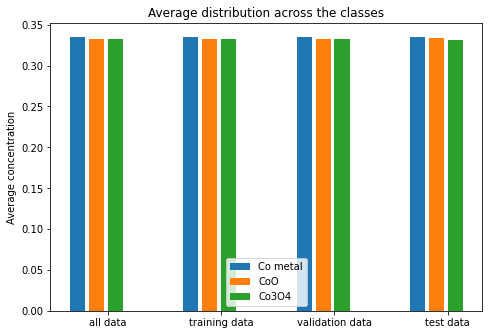

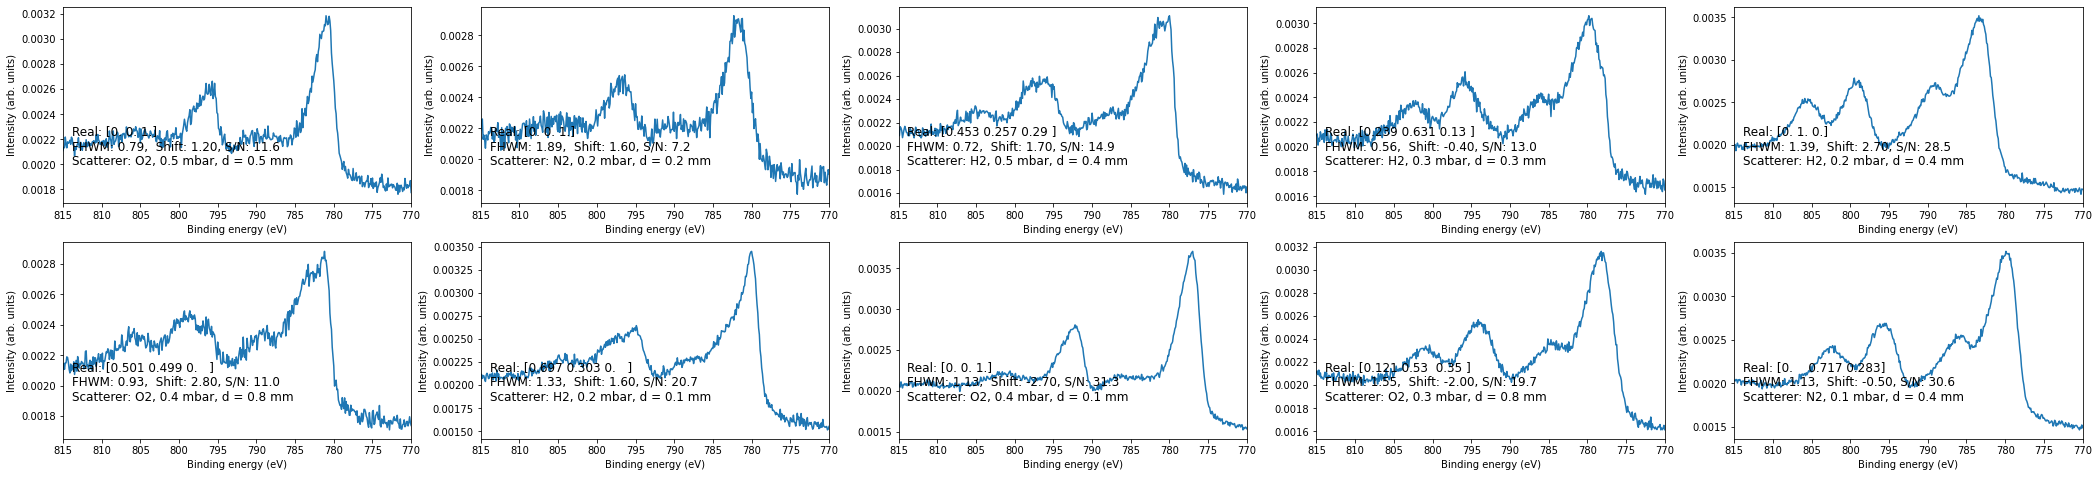

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        clf.load_data_preprocess(
            input_filepath = clf.logging.hyperparams['input_filepath'],
            no_of_examples = clf.logging.hyperparams['no_of_examples'],
            train_test_split = clf.logging.hyperparams['train_test_split'],
            train_val_split = clf.logging.hyperparams['train_val_split'])
                
# Check how the examples are distributed across the classes.
class_distribution = clf.datahandler.check_class_distribution(clf.task)
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'train')  

### Load the model

In [ ]:
from tensorflow.keras import backend as K
clf.load_model(compile_model = True)

Loaded model from disk.


### Summarize the model

Model: "Loaded_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 451, 1)]     0           []                               
                                                                                                  
 conv_1_short (Conv1D)          (None, 451, 12)      72          ['input_1[0][0]']                
                                                                                                  
 conv_1_medium (Conv1D)         (None, 451, 12)      132         ['input_1[0][0]']                
                                                                                                  
 conv_1_long (Conv1D)           (None, 451, 12)      192         ['input_1[0][0]']                
                                                                                       

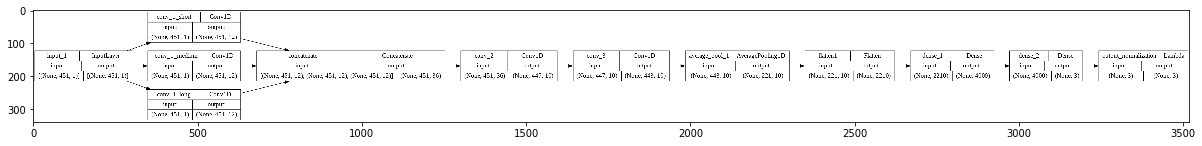

In [ ]:
# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Show predictions with current model

1250/1250 [==============================] - 3s 2ms/step
Prediction done!
Train:
real: [0.248 0.    0.752] pred: [2.5657108e-01 4.6718138e-04 7.4296170e-01]
real: [0.    0.167 0.833] pred: [1.4666139e-04 1.8289740e-01 8.1695592e-01]
real: [0. 1. 0.] pred: [2.2119510e-05 9.9930274e-01 6.7520433e-04]
real: [1. 0. 0.] pred: [9.99896467e-01 1.87942646e-07 1.03340826e-04]
real: [0.573 0.427 0.   ] pred: [0.55949205 0.4307342  0.00977376]
Test:
real: [0.606 0.    0.394] pred: [6.0449696e-01 1.0259774e-06 3.9550203e-01]
real: [0.417 0.    0.583] pred: [4.0914801e-01 2.1033361e-06 5.9084994e-01]
real: [0.223 0.224 0.554] pred: [0.306521   0.20152421 0.49195477]
real: [0.267 0.733 0.   ] pred: [0.26615277 0.71060693 0.02324028]
real: [0. 0. 1.] pred: [2.0261894e-05 7.1001724e-09 9.9997973e-01]
Calculating loss for each example...
Done!


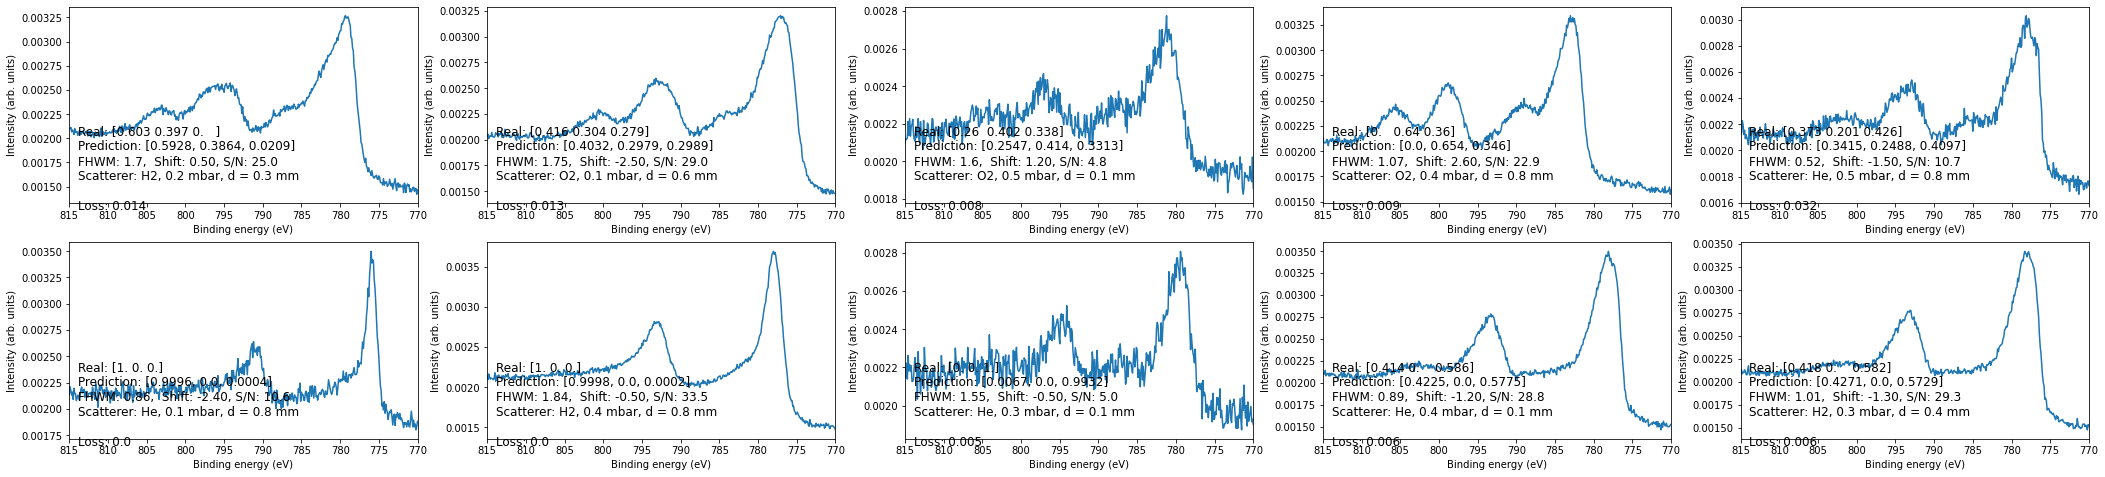

In [ ]:
pred_train_intermediate, pred_test_intermediate = clf.predict()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(clf.datahandler.y_train[i],3)),
          'pred: ' + str(pred_train_intermediate[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(clf.datahandler.y_test[i],3)),
          'pred: ' + str(pred_test_intermediate[i]))
    
clf.plot_random(no_of_spectra=10, dataset='test', with_prediction=True)

In [ ]:
500-clf.logging.hyperparams["epochs_trained"]

275

### Train

In [ ]:
epochs = 275

#new_learning_rate = 5e-06

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = clf.logging.hyperparams['batch_size'],
                 verbose = 1,)
#                 new_learning_rate = new_learning_rate)

Epoch 226/500
   1/4000 [..............................] - ETA: 1:59:57 - loss: 0.0137 - mse: 6.5618e-04

4000/4000 [==============================] - ETA: 0s - loss: 0.0154 - mse: 9.3501e-04

4000/4000 [==============================] - 33s 8ms/step - loss: 0.0154 - mse: 9.3501e-04 - val_loss: 0.0153 - val_mse: 9.1825e-04
Epoch 227/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0154 - mse: 9.3967e-04 - val_loss: 0.0157 - val_mse: 9.9775e-04
Epoch 228/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0153 - mse: 9.3601e-04 - val_loss: 0.0154 - val_mse: 9.1640e-04
Epoch 229/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0153 - mse: 9.3059e-04 - val_loss: 0.0156 - val_mse: 9.9618e-04
Epoch 230/500
3997/4000 [============================>.] - ETA: 0s - loss: 0.0153 - mse: 9.2781e-04

4000/4000 [==============================] - 31s 8ms/step - loss: 0.0153 - mse: 9.2766e-04 - val_loss: 0.0153 - val_mse: 0.0010
Epoch 231/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0152 - mse: 9.2667e-04 - val_loss: 0.0157 - val_mse: 9.6425e-04
Epoch 232/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0152 - mse: 9.1688e-04 - val_loss: 0.0155 - val_mse: 9.2265e-04
Epoch 233/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0151 - mse: 9.1756e-04 - val_loss: 0.0153 - val_mse: 9.1725e-04
Epoch 234/500
3998/4000 [============================>.] - ETA: 0s - loss: 0.0151 - mse: 9.1164e-04

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0151 - mse: 9.1171e-04 - val_loss: 0.0152 - val_mse: 8.7048e-04
Epoch 235/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0151 - mse: 9.1355e-04 - val_loss: 0.0156 - val_mse: 0.0011
Epoch 236/500
3995/4000 [============================>.] - ETA: 0s - loss: 0.0151 - mse: 9.0726e-04

4000/4000 [==============================] - 30s 7ms/step - loss: 0.0151 - mse: 9.0743e-04 - val_loss: 0.0147 - val_mse: 8.6779e-04
Epoch 237/500
4000/4000 [==============================] - 29s 7ms/step - loss: 0.0150 - mse: 9.0298e-04 - val_loss: 0.0151 - val_mse: 9.0501e-04
Epoch 238/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0150 - mse: 8.9895e-04 - val_loss: 0.0149 - val_mse: 9.4853e-04
Epoch 239/500
4000/4000 [==============================] - ETA: 0s - loss: 0.0149 - mse: 8.9916e-04

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0149 - mse: 8.9916e-04 - val_loss: 0.0146 - val_mse: 9.0368e-04
Epoch 240/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0149 - mse: 8.9169e-04 - val_loss: 0.0146 - val_mse: 8.3684e-04
Epoch 241/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0148 - mse: 8.9215e-04 - val_loss: 0.0150 - val_mse: 9.0498e-04
Epoch 242/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0148 - mse: 8.9056e-04 - val_loss: 0.0150 - val_mse: 8.6645e-04
Epoch 243/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0148 - mse: 8.8749e-04 - val_loss: 0.0161 - val_mse: 0.0012
Epoch 244/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0147 - mse: 8.8331e-04 - val_loss: 0.0151 - val_mse: 9.0050e-04
Epoch 245/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0147 - mse: 8.7983e-04 - val_loss: 0.0153 - val_mse: 0.0011


4000/4000 [==============================] - 27s 7ms/step - loss: 0.0146 - mse: 8.6479e-04 - val_loss: 0.0144 - val_mse: 8.5175e-04
Epoch 250/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0146 - mse: 8.7106e-04 - val_loss: 0.0152 - val_mse: 9.0387e-04
Epoch 251/500
3995/4000 [============================>.] - ETA: 0s - loss: 0.0145 - mse: 8.6018e-04

4000/4000 [==============================] - 29s 7ms/step - loss: 0.0145 - mse: 8.6000e-04 - val_loss: 0.0143 - val_mse: 8.1826e-04
Epoch 252/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0146 - mse: 8.6370e-04 - val_loss: 0.0145 - val_mse: 9.2008e-04
Epoch 253/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0145 - mse: 8.5500e-04 - val_loss: 0.0156 - val_mse: 8.8269e-04
Epoch 254/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0144 - mse: 8.5562e-04 - val_loss: 0.0151 - val_mse: 0.0010
Epoch 255/500
3994/4000 [============================>.] - ETA: 0s - loss: 0.0145 - mse: 8.5604e-04

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0145 - mse: 8.5604e-04 - val_loss: 0.0142 - val_mse: 8.3829e-04
Epoch 256/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0144 - mse: 8.4768e-04 - val_loss: 0.0143 - val_mse: 8.7945e-04
Epoch 257/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0143 - mse: 8.5373e-04 - val_loss: 0.0151 - val_mse: 0.0010
Epoch 258/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0143 - mse: 8.4357e-04 - val_loss: 0.0142 - val_mse: 8.2375e-04
Epoch 259/500
4000/4000 [==============================] - 29s 7ms/step - loss: 0.0143 - mse: 8.4402e-04 - val_loss: 0.0145 - val_mse: 8.1507e-04
Epoch 260/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0142 - mse: 8.3510e-04 - val_loss: 0.0143 - val_mse: 8.2327e-04
Epoch 261/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0143 - mse: 8.4027e-04 - val_loss: 0.0152 - val_mse: 8.5158e

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0142 - mse: 8.2727e-04 - val_loss: 0.0141 - val_mse: 8.5339e-04
Epoch 263/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0142 - mse: 8.4145e-04 - val_loss: 0.0144 - val_mse: 8.1931e-04
Epoch 264/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0142 - mse: 8.3461e-04 - val_loss: 0.0146 - val_mse: 8.5088e-04
Epoch 265/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0141 - mse: 8.2689e-04 - val_loss: 0.0146 - val_mse: 8.2552e-04
Epoch 266/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0141 - mse: 8.2267e-04 - val_loss: 0.0143 - val_mse: 8.6601e-04
Epoch 267/500
4000/4000 [==============================] - ETA: 0s - loss: 0.0140 - mse: 8.2201e-04

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0140 - mse: 8.2201e-04 - val_loss: 0.0138 - val_mse: 8.1520e-04
Epoch 268/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0141 - mse: 8.1992e-04 - val_loss: 0.0140 - val_mse: 7.8058e-04
Epoch 269/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0140 - mse: 8.1795e-04 - val_loss: 0.0155 - val_mse: 9.0816e-04
Epoch 270/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0140 - mse: 8.2124e-04 - val_loss: 0.0144 - val_mse: 9.5725e-04
Epoch 271/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0140 - mse: 8.1266e-04 - val_loss: 0.0141 - val_mse: 8.2876e-04
Epoch 272/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0140 - mse: 8.2197e-04 - val_loss: 0.0161 - val_mse: 9.1517e-04
Epoch 273/500
3993/4000 [============================>.] - ETA: 0s - loss: 0.0139 - mse: 8.0802e-04

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0139 - mse: 8.0776e-04 - val_loss: 0.0137 - val_mse: 8.0577e-04
Epoch 274/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0139 - mse: 8.0950e-04 - val_loss: 0.0140 - val_mse: 8.6507e-04
Epoch 275/500
3994/4000 [============================>.] - ETA: 0s - loss: 0.0139 - mse: 8.0741e-04

4000/4000 [==============================] - 29s 7ms/step - loss: 0.0139 - mse: 8.0790e-04 - val_loss: 0.0136 - val_mse: 8.2527e-04
Epoch 276/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0139 - mse: 8.0377e-04 - val_loss: 0.0141 - val_mse: 7.7959e-04
Epoch 277/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0137 - mse: 7.9126e-04 - val_loss: 0.0150 - val_mse: 0.0010
Epoch 278/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0138 - mse: 7.9972e-04 - val_loss: 0.0138 - val_mse: 8.0000e-04
Epoch 279/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0137 - mse: 7.9098e-04 - val_loss: 0.0190 - val_mse: 0.0013
Epoch 280/500
3999/4000 [============================>.] - ETA: 0s - loss: 0.0138 - mse: 7.9681e-04

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0138 - mse: 7.9673e-04 - val_loss: 0.0136 - val_mse: 7.6994e-04
Epoch 281/500
3999/4000 [============================>.] - ETA: 0s - loss: 0.0137 - mse: 7.8898e-04

4000/4000 [==============================] - 30s 8ms/step - loss: 0.0137 - mse: 7.8899e-04 - val_loss: 0.0135 - val_mse: 8.1549e-04
Epoch 282/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0136 - mse: 7.8412e-04 - val_loss: 0.0136 - val_mse: 7.5248e-04
Epoch 283/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0137 - mse: 7.9397e-04 - val_loss: 0.0136 - val_mse: 7.9399e-04
Epoch 284/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0136 - mse: 7.8691e-04 - val_loss: 0.0137 - val_mse: 7.7025e-04
Epoch 285/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0136 - mse: 7.8391e-04 - val_loss: 0.0135 - val_mse: 7.7759e-04
Epoch 286/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0135 - mse: 7.7881e-04 - val_loss: 0.0141 - val_mse: 8.1042e-04
Epoch 287/500
3992/4000 [============================>.] - ETA: 0s - loss: 0.0135 - mse: 7.7832e-04

4000/4000 [==============================] - 29s 7ms/step - loss: 0.0135 - mse: 7.7770e-04 - val_loss: 0.0135 - val_mse: 8.0173e-04
Epoch 288/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0136 - mse: 7.7806e-04 - val_loss: 0.0142 - val_mse: 7.8969e-04
Epoch 289/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0135 - mse: 7.7135e-04 - val_loss: 0.0135 - val_mse: 8.2302e-04
Epoch 290/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0135 - mse: 7.6916e-04 - val_loss: 0.0138 - val_mse: 7.7993e-04
Epoch 291/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0134 - mse: 7.6640e-04 - val_loss: 0.0137 - val_mse: 7.6118e-04
Epoch 292/500
3995/4000 [============================>.] - ETA: 0s - loss: 0.0134 - mse: 7.6638e-04

4000/4000 [==============================] - 30s 8ms/step - loss: 0.0134 - mse: 7.6594e-04 - val_loss: 0.0133 - val_mse: 8.1353e-04
Epoch 293/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0134 - mse: 7.6430e-04 - val_loss: 0.0133 - val_mse: 7.3636e-04
Epoch 294/500
4000/4000 [==============================] - ETA: 0s - loss: 0.0134 - mse: 7.6358e-04

4000/4000 [==============================] - 29s 7ms/step - loss: 0.0134 - mse: 7.6358e-04 - val_loss: 0.0132 - val_mse: 7.3538e-04
Epoch 295/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0134 - mse: 7.6141e-04 - val_loss: 0.0134 - val_mse: 7.5927e-04
Epoch 296/500
4000/4000 [==============================] - 29s 7ms/step - loss: 0.0133 - mse: 7.5411e-04 - val_loss: 0.0139 - val_mse: 8.9818e-04
Epoch 297/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0133 - mse: 7.5752e-04 - val_loss: 0.0133 - val_mse: 7.5466e-04
Epoch 298/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0133 - mse: 7.6368e-04 - val_loss: 0.0142 - val_mse: 7.6552e-04
Epoch 299/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0133 - mse: 7.6685e-04 - val_loss: 0.0136 - val_mse: 8.5398e-04
Epoch 300/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.0132 - mse: 7.4647e-04

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0132 - mse: 7.4651e-04 - val_loss: 0.0131 - val_mse: 7.2779e-04
Epoch 301/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0132 - mse: 7.4893e-04 - val_loss: 0.0136 - val_mse: 7.6006e-04
Epoch 302/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0132 - mse: 7.4800e-04 - val_loss: 0.0134 - val_mse: 7.3897e-04
Epoch 303/500
3997/4000 [============================>.] - ETA: 0s - loss: 0.0131 - mse: 7.3849e-04

4000/4000 [==============================] - 29s 7ms/step - loss: 0.0132 - mse: 7.4166e-04 - val_loss: 0.0131 - val_mse: 7.3525e-04
Epoch 304/500
4000/4000 [==============================] - 29s 7ms/step - loss: 0.0132 - mse: 7.4098e-04 - val_loss: 0.0134 - val_mse: 7.5068e-04
Epoch 305/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0131 - mse: 7.4300e-04 - val_loss: 0.0131 - val_mse: 7.5696e-04
Epoch 306/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0131 - mse: 7.3953e-04 - val_loss: 0.0133 - val_mse: 7.5290e-04
Epoch 307/500
3999/4000 [============================>.] - ETA: 0s - loss: 0.0131 - mse: 7.3738e-04

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0131 - mse: 7.3729e-04 - val_loss: 0.0128 - val_mse: 7.2942e-04
Epoch 308/500
4000/4000 [==============================] - 28s 7ms/step - loss: 0.0131 - mse: 7.3951e-04 - val_loss: 0.0129 - val_mse: 7.1151e-04
Epoch 309/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0131 - mse: 7.3425e-04 - val_loss: 0.0129 - val_mse: 7.1769e-04
Epoch 310/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0131 - mse: 7.4245e-04 - val_loss: 0.0136 - val_mse: 7.6323e-04
Epoch 311/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0130 - mse: 7.3628e-04 - val_loss: 0.0136 - val_mse: 8.2199e-04
Epoch 312/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0130 - mse: 7.2883e-04 - val_loss: 0.0132 - val_mse: 7.8624e-04
Epoch 313/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0130 - mse: 7.2545e-04 - val_loss: 0.0131 - val_mse: 7.3

4000/4000 [==============================] - 29s 7ms/step - loss: 0.0128 - mse: 7.0988e-04 - val_loss: 0.0126 - val_mse: 7.1558e-04
Epoch 322/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0128 - mse: 7.1347e-04 - val_loss: 0.0127 - val_mse: 7.2554e-04
Epoch 323/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0127 - mse: 7.0308e-04 - val_loss: 0.0129 - val_mse: 7.1399e-04
Epoch 324/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0127 - mse: 7.0966e-04 - val_loss: 0.0136 - val_mse: 7.3472e-04
Epoch 325/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0127 - mse: 7.1768e-04 - val_loss: 0.0129 - val_mse: 7.1874e-04
Epoch 326/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0127 - mse: 7.1418e-04 - val_loss: 0.0129 - val_mse: 7.3092e-04
Epoch 327/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0127 - mse: 7.1179e-04 - val_loss: 0.0131 - val_mse: 7.1

4000/4000 [==============================] - 30s 7ms/step - loss: 0.0125 - mse: 6.8757e-04 - val_loss: 0.0123 - val_mse: 6.8996e-04
Epoch 342/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0125 - mse: 6.8594e-04 - val_loss: 0.0128 - val_mse: 7.3115e-04
Epoch 343/500
3993/4000 [============================>.] - ETA: 0s - loss: 0.0124 - mse: 6.7585e-04

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0124 - mse: 6.7595e-04 - val_loss: 0.0123 - val_mse: 6.7612e-04
Epoch 344/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0124 - mse: 6.7406e-04 - val_loss: 0.0126 - val_mse: 6.7754e-04
Epoch 345/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0124 - mse: 6.8115e-04 - val_loss: 0.0123 - val_mse: 6.7799e-04
Epoch 346/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0124 - mse: 6.7789e-04 - val_loss: 0.0124 - val_mse: 6.9737e-04
Epoch 347/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0123 - mse: 6.7458e-04 - val_loss: 0.0130 - val_mse: 7.2509e-04
Epoch 348/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0124 - mse: 6.7604e-04 - val_loss: 0.0137 - val_mse: 8.8469e-04
Epoch 349/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0123 - mse: 6.7291e-04 - val_loss: 0.0125 - val_mse: 7.0

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0123 - mse: 6.7568e-04 - val_loss: 0.0121 - val_mse: 6.7282e-04
Epoch 353/500
4000/4000 [==============================] - 28s 7ms/step - loss: 0.0122 - mse: 6.6810e-04 - val_loss: 0.0123 - val_mse: 6.6729e-04
Epoch 354/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0122 - mse: 6.6227e-04 - val_loss: 0.0126 - val_mse: 7.3166e-04
Epoch 355/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0123 - mse: 6.7067e-04 - val_loss: 0.0124 - val_mse: 6.8209e-04
Epoch 356/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0122 - mse: 6.6609e-04 - val_loss: 0.0124 - val_mse: 6.6929e-04
Epoch 357/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0122 - mse: 6.6811e-04 - val_loss: 0.0121 - val_mse: 7.0799e-04
Epoch 358/500
3993/4000 [============================>.] - ETA: 0s - loss: 0.0122 - mse: 6.6435e-04

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0122 - mse: 6.6419e-04 - val_loss: 0.0120 - val_mse: 6.6707e-04
Epoch 359/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0122 - mse: 6.6009e-04 - val_loss: 0.0129 - val_mse: 6.9046e-04
Epoch 360/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0121 - mse: 6.5383e-04 - val_loss: 0.0123 - val_mse: 6.5801e-04
Epoch 361/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0122 - mse: 6.5945e-04 - val_loss: 0.0132 - val_mse: 7.5382e-04
Epoch 362/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.0121 - mse: 6.5441e-04

4000/4000 [==============================] - 31s 8ms/step - loss: 0.0121 - mse: 6.5453e-04 - val_loss: 0.0120 - val_mse: 6.5382e-04
Epoch 363/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0121 - mse: 6.5349e-04 - val_loss: 0.0122 - val_mse: 6.5742e-04
Epoch 364/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0121 - mse: 6.5153e-04 - val_loss: 0.0129 - val_mse: 6.9093e-04
Epoch 365/500
4000/4000 [==============================] - 28s 7ms/step - loss: 0.0121 - mse: 6.5764e-04 - val_loss: 0.0142 - val_mse: 9.3429e-04
Epoch 366/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0121 - mse: 6.5183e-04 - val_loss: 0.0124 - val_mse: 6.6709e-04
Epoch 367/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0121 - mse: 6.5082e-04 - val_loss: 0.0123 - val_mse: 6.5694e-04
Epoch 368/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0120 - mse: 6.4531e-04 - val_loss: 0.0123 - val_mse: 6.7

4000/4000 [==============================] - 30s 8ms/step - loss: 0.0119 - mse: 6.3759e-04 - val_loss: 0.0119 - val_mse: 6.5024e-04
Epoch 375/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0119 - mse: 6.4270e-04 - val_loss: 0.0122 - val_mse: 7.1103e-04
Epoch 376/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0120 - mse: 6.4272e-04 - val_loss: 0.0124 - val_mse: 6.9388e-04
Epoch 377/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0119 - mse: 6.3793e-04 - val_loss: 0.0132 - val_mse: 7.1140e-04
Epoch 378/500
3996/4000 [============================>.] - ETA: 0s - loss: 0.0118 - mse: 6.3406e-04

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0118 - mse: 6.3377e-04 - val_loss: 0.0118 - val_mse: 6.4411e-04
Epoch 379/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0119 - mse: 6.2977e-04 - val_loss: 0.0122 - val_mse: 6.5191e-04
Epoch 380/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0118 - mse: 6.3519e-04 - val_loss: 0.0120 - val_mse: 6.6049e-04
Epoch 381/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0118 - mse: 6.3236e-04 - val_loss: 0.0129 - val_mse: 6.9320e-04
Epoch 382/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0118 - mse: 6.3199e-04 - val_loss: 0.0121 - val_mse: 6.6090e-04
Epoch 383/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0118 - mse: 6.3095e-04 - val_loss: 0.0139 - val_mse: 7.4520e-04
Epoch 384/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0118 - mse: 6.3140e-04 - val_loss: 0.0128 - val_mse: 6.8

4000/4000 [==============================] - 29s 7ms/step - loss: 0.0117 - mse: 6.2495e-04 - val_loss: 0.0116 - val_mse: 6.3178e-04
Epoch 389/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0117 - mse: 6.2335e-04 - val_loss: 0.0119 - val_mse: 6.7480e-04
Epoch 390/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0117 - mse: 6.3354e-04 - val_loss: 0.0119 - val_mse: 6.3550e-04
Epoch 391/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0117 - mse: 6.2579e-04 - val_loss: 0.0125 - val_mse: 6.7610e-04
Epoch 392/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0117 - mse: 6.2419e-04 - val_loss: 0.0119 - val_mse: 6.3318e-04
Epoch 393/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0117 - mse: 6.2712e-04 - val_loss: 0.0120 - val_mse: 6.5696e-04
Epoch 394/500
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0117 - mse: 6.2381e-04 - val_loss: 0.0129 - val_mse: 7.0

4000/4000 [==============================] - 29s 7ms/step - loss: 0.0115 - mse: 6.0270e-04 - val_loss: 0.0115 - val_mse: 6.2989e-04
Epoch 413/500
4000/4000 [==============================] - 29s 7ms/step - loss: 0.0114 - mse: 5.9944e-04 - val_loss: 0.0126 - val_mse: 6.6449e-04
Epoch 414/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0115 - mse: 6.0421e-04 - val_loss: 0.0125 - val_mse: 6.8369e-04
Epoch 415/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0114 - mse: 5.9870e-04 - val_loss: 0.0121 - val_mse: 6.4919e-04
Epoch 416/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0114 - mse: 5.9902e-04 - val_loss: 0.0117 - val_mse: 6.3052e-04
Epoch 417/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0114 - mse: 5.9445e-04 - val_loss: 0.0119 - val_mse: 6.3357e-04
Epoch 418/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0114 - mse: 5.9389e-04 - val_loss: 0.0118 - val_mse: 6.2

4000/4000 [==============================] - 29s 7ms/step - loss: 0.0113 - mse: 5.9333e-04 - val_loss: 0.0115 - val_mse: 6.1674e-04
Epoch 425/500
4000/4000 [==============================] - 28s 7ms/step - loss: 0.0113 - mse: 5.8655e-04 - val_loss: 0.0117 - val_mse: 6.3040e-04
Epoch 426/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0113 - mse: 5.8775e-04 - val_loss: 0.0121 - val_mse: 6.3063e-04
Epoch 427/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0113 - mse: 5.8711e-04 - val_loss: 0.0121 - val_mse: 6.5509e-04
Epoch 428/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0113 - mse: 5.8656e-04 - val_loss: 0.0121 - val_mse: 6.4568e-04
Epoch 429/500
3993/4000 [============================>.] - ETA: 0s - loss: 0.0113 - mse: 5.9032e-04

4000/4000 [==============================] - 30s 8ms/step - loss: 0.0113 - mse: 5.9024e-04 - val_loss: 0.0114 - val_mse: 6.0945e-04
Epoch 430/500
4000/4000 [==============================] - 28s 7ms/step - loss: 0.0112 - mse: 5.8030e-04 - val_loss: 0.0116 - val_mse: 6.3209e-04
Epoch 431/500
4000/4000 [==============================] - 28s 7ms/step - loss: 0.0112 - mse: 5.8713e-04 - val_loss: 0.0121 - val_mse: 6.4041e-04
Epoch 432/500
3998/4000 [============================>.] - ETA: 0s - loss: 0.0112 - mse: 5.8276e-04

4000/4000 [==============================] - 30s 7ms/step - loss: 0.0112 - mse: 5.8263e-04 - val_loss: 0.0113 - val_mse: 6.1199e-04
Epoch 433/500
4000/4000 [==============================] - 28s 7ms/step - loss: 0.0113 - mse: 5.8632e-04 - val_loss: 0.0114 - val_mse: 6.1001e-04
Epoch 434/500
4000/4000 [==============================] - 29s 7ms/step - loss: 0.0112 - mse: 5.8362e-04 - val_loss: 0.0121 - val_mse: 6.6261e-04
Epoch 435/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0112 - mse: 5.8599e-04 - val_loss: 0.0115 - val_mse: 6.1413e-04
Epoch 436/500
4000/4000 [==============================] - 29s 7ms/step - loss: 0.0112 - mse: 5.7546e-04 - val_loss: 0.0118 - val_mse: 6.2467e-04
Epoch 437/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0112 - mse: 5.8130e-04 - val_loss: 0.0115 - val_mse: 6.0521e-04
Epoch 438/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0112 - mse: 5.7911e-04 - val_loss: 0.0114 - val_mse: 6.1

4000/4000 [==============================] - 28s 7ms/step - loss: 0.0111 - mse: 5.7633e-04 - val_loss: 0.0111 - val_mse: 5.9985e-04
Epoch 440/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0112 - mse: 5.7809e-04 - val_loss: 0.0115 - val_mse: 6.1168e-04
Epoch 441/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0111 - mse: 5.7351e-04 - val_loss: 0.0115 - val_mse: 6.1845e-04
Epoch 442/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0112 - mse: 5.7710e-04 - val_loss: 0.0122 - val_mse: 6.6066e-04
Epoch 443/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0111 - mse: 5.7747e-04 - val_loss: 0.0113 - val_mse: 5.9945e-04
Epoch 444/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0111 - mse: 5.7828e-04 - val_loss: 0.0116 - val_mse: 6.2272e-04
Epoch 445/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0111 - mse: 5.7597e-04 - val_loss: 0.0115 - val_mse: 6.0

4000/4000 [==============================] - 30s 7ms/step - loss: 0.0111 - mse: 5.7283e-04 - val_loss: 0.0111 - val_mse: 5.9845e-04
Epoch 447/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0111 - mse: 5.7151e-04 - val_loss: 0.0113 - val_mse: 6.0623e-04
Epoch 448/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0111 - mse: 5.7113e-04 - val_loss: 0.0117 - val_mse: 6.1102e-04
Epoch 449/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0111 - mse: 5.7250e-04 - val_loss: 0.0112 - val_mse: 5.9755e-04
Epoch 450/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0110 - mse: 5.6982e-04 - val_loss: 0.0112 - val_mse: 6.1087e-04
Epoch 451/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0110 - mse: 5.6976e-04 - val_loss: 0.0113 - val_mse: 6.3124e-04
Epoch 452/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0110 - mse: 5.6690e-04 - val_loss: 0.0126 - val_mse: 7.3

4000/4000 [==============================] - 30s 7ms/step - loss: 0.0109 - mse: 5.5218e-04 - val_loss: 0.0110 - val_mse: 5.8800e-04
Epoch 474/500
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0108 - mse: 5.4973e-04 - val_loss: 0.0123 - val_mse: 6.4557e-04
Epoch 475/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0108 - mse: 5.5433e-04 - val_loss: 0.0111 - val_mse: 6.0870e-04
Epoch 476/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0108 - mse: 5.5295e-04 - val_loss: 0.0131 - val_mse: 6.7007e-04
Epoch 477/500
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0108 - mse: 5.5811e-04 - val_loss: 0.0111 - val_mse: 5.8353e-04
Epoch 478/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0108 - mse: 5.4929e-04 - val_loss: 0.0119 - val_mse: 6.1603e-04
Epoch 479/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0108 - mse: 5.4832e-04 - val_loss: 0.0119 - val_mse: 6.2

4000/4000 [==============================] - 30s 7ms/step - loss: 0.0107 - mse: 5.4161e-04 - val_loss: 0.0110 - val_mse: 5.7758e-04
Epoch 492/500
3995/4000 [============================>.] - ETA: 0s - loss: 0.0107 - mse: 5.4393e-04

4000/4000 [==============================] - 30s 7ms/step - loss: 0.0107 - mse: 5.4366e-04 - val_loss: 0.0109 - val_mse: 5.8311e-04
Epoch 493/500
3999/4000 [============================>.] - ETA: 0s - loss: 0.0107 - mse: 5.4308e-04

4000/4000 [==============================] - 29s 7ms/step - loss: 0.0107 - mse: 5.4332e-04 - val_loss: 0.0108 - val_mse: 5.6291e-04
Epoch 494/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0107 - mse: 5.4164e-04 - val_loss: 0.0116 - val_mse: 6.0303e-04
Epoch 495/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0107 - mse: 5.3839e-04 - val_loss: 0.0112 - val_mse: 6.0335e-04
Epoch 496/500
4000/4000 [==============================] - 28s 7ms/step - loss: 0.0106 - mse: 5.4097e-04 - val_loss: 0.0110 - val_mse: 5.7704e-04
Epoch 497/500
4000/4000 [==============================] - 29s 7ms/step - loss: 0.0106 - mse: 5.3484e-04 - val_loss: 0.0121 - val_mse: 6.1599e-04
Epoch 498/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0106 - mse: 5.3678e-04 - val_loss: 0.0116 - val_mse: 6.0413e-04
Epoch 499/500
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0107 - mse: 5.4440e-04 - val_loss: 0.0112 - val_mse: 5.9

### Show predictions with current model

1250/1250 [==============================] - 3s 2ms/step
Prediction done!
Train:
real: [0.248 0.    0.752] pred: [2.63621807e-01 1.16634306e-04 7.36261606e-01]
real: [0.    0.167 0.833] pred: [3.4706543e-06 1.9819053e-01 8.0180603e-01]
real: [0. 1. 0.] pred: [5.4861921e-06 9.9992526e-01 6.9234084e-05]
real: [1. 0. 0.] pred: [9.9973923e-01 2.2585634e-06 2.5854463e-04]
real: [0.573 0.427 0.   ] pred: [0.57166874 0.4274341  0.0008972 ]
Test:
real: [0.606 0.    0.394] pred: [6.0612768e-01 4.7751502e-07 3.9387184e-01]
real: [0.417 0.    0.583] pred: [4.1799828e-01 2.6846835e-06 5.8199900e-01]
real: [0.223 0.224 0.554] pred: [0.26703107 0.2184602  0.5145087 ]
real: [0.267 0.733 0.   ] pred: [0.24962963 0.74867976 0.00169056]
real: [0. 0. 1.] pred: [1.3140392e-07 5.5855509e-10 9.9999988e-01]


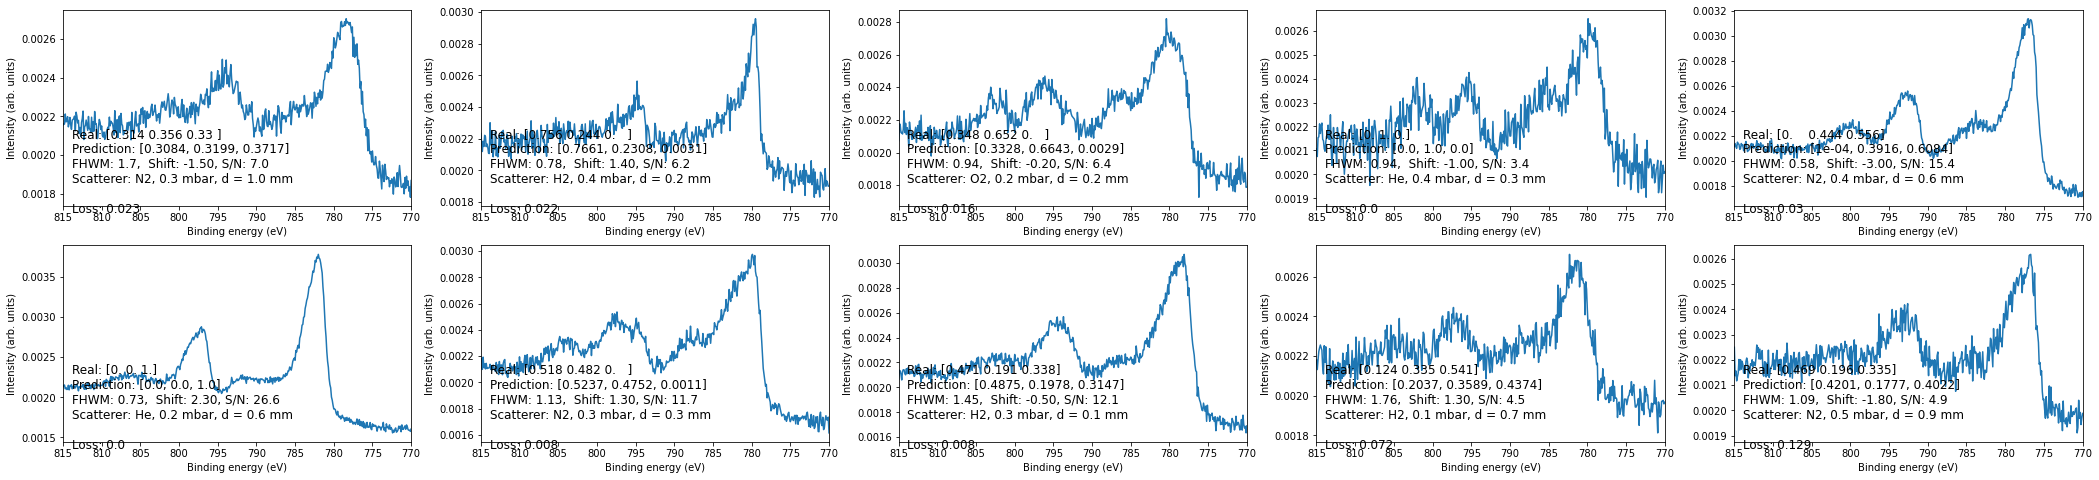

In [ ]:
pred_train_intermediate, pred_test_intermediate = clf.predict()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(y_train[i],3)),
          'pred: ' + str(pred_train_intermediate[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(y_test[i],3)),
          'pred: ' + str(pred_test_intermediate[i]))
    
clf.plot_random(no_of_spectra=10, dataset='test', with_prediction=True)

### Train

In [ ]:
epochs = 1000

#new_learning_rate = 5e-06

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = clf.logging.hyperparams['batch_size'],
                 verbose = 1,)
#                 new_learning_rate = new_learning_rate)

### Plot loss

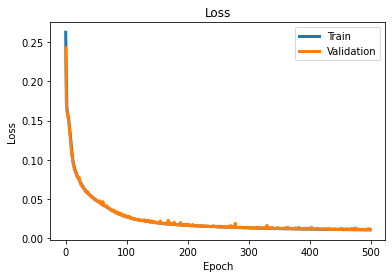

In [ ]:
graph = clfutils.TrainingGraphs(clf.logging.history, clf.logging.fig_dir)
graph.plot_loss(to_file = True)
if clf.task != "regression":
    graph.plot_accuracy(to_file = True)

### Evaluate on test data

In [ ]:
if clf.task == "regression":
    test_loss = clf.evaluate()
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))
    
else:
    score = clf.evaluate()
    test_loss, test_accuracy = score[0], score[1]
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))
    print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))

1250/1250 [==============================] - 4s 3ms/step - loss: 0.0115 - mse: 6.0722e-04
Evaluation done! 

Test loss: [0.01153956 0.00060722]


###  Predict on train and test data

In [ ]:
pred_train, pred_test = clf.predict()
if clf.task == "classification":
    pred_train_classes, pred_test_classes = clf.predict_classes()

1250/1250 [==============================] - 3s 2ms/step
Prediction done!


### Show some predictions

#### 10 random training samples

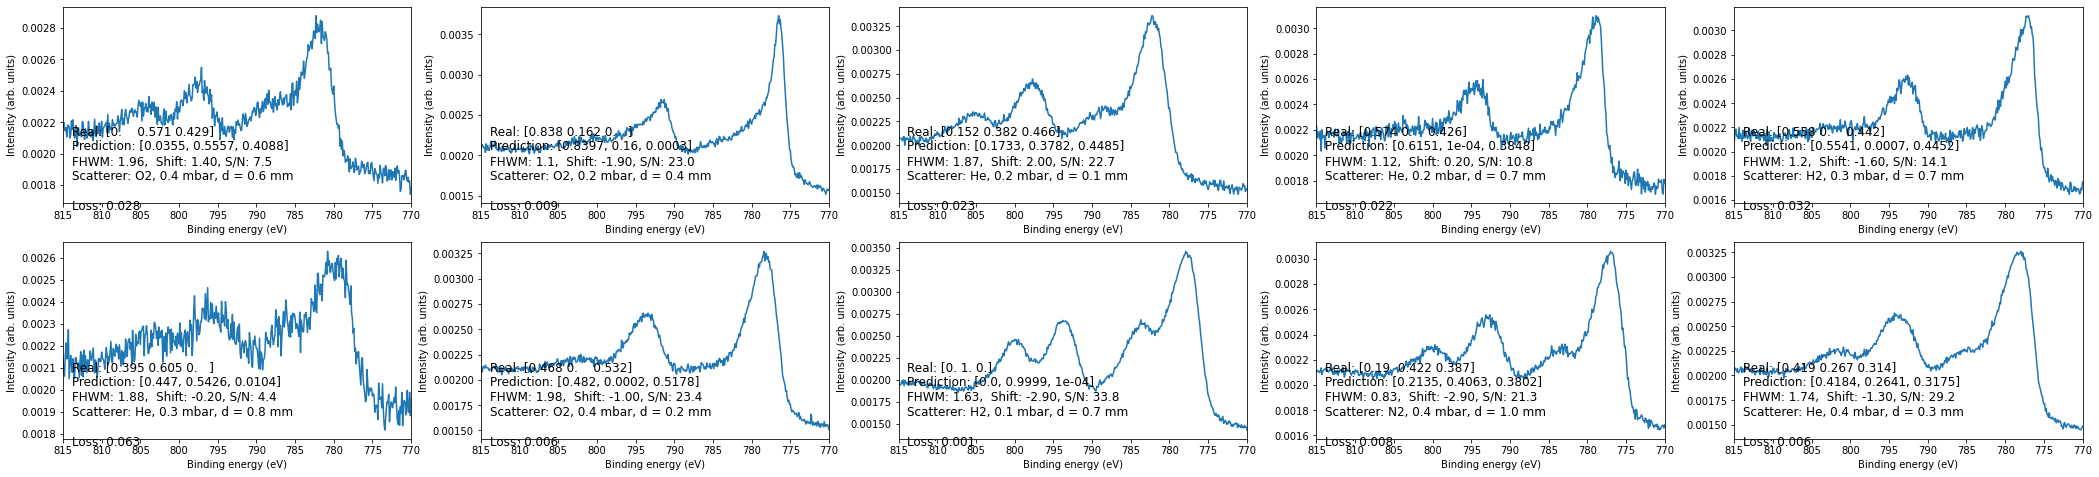

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = "train", with_prediction = True)  

#### 10 random test samples

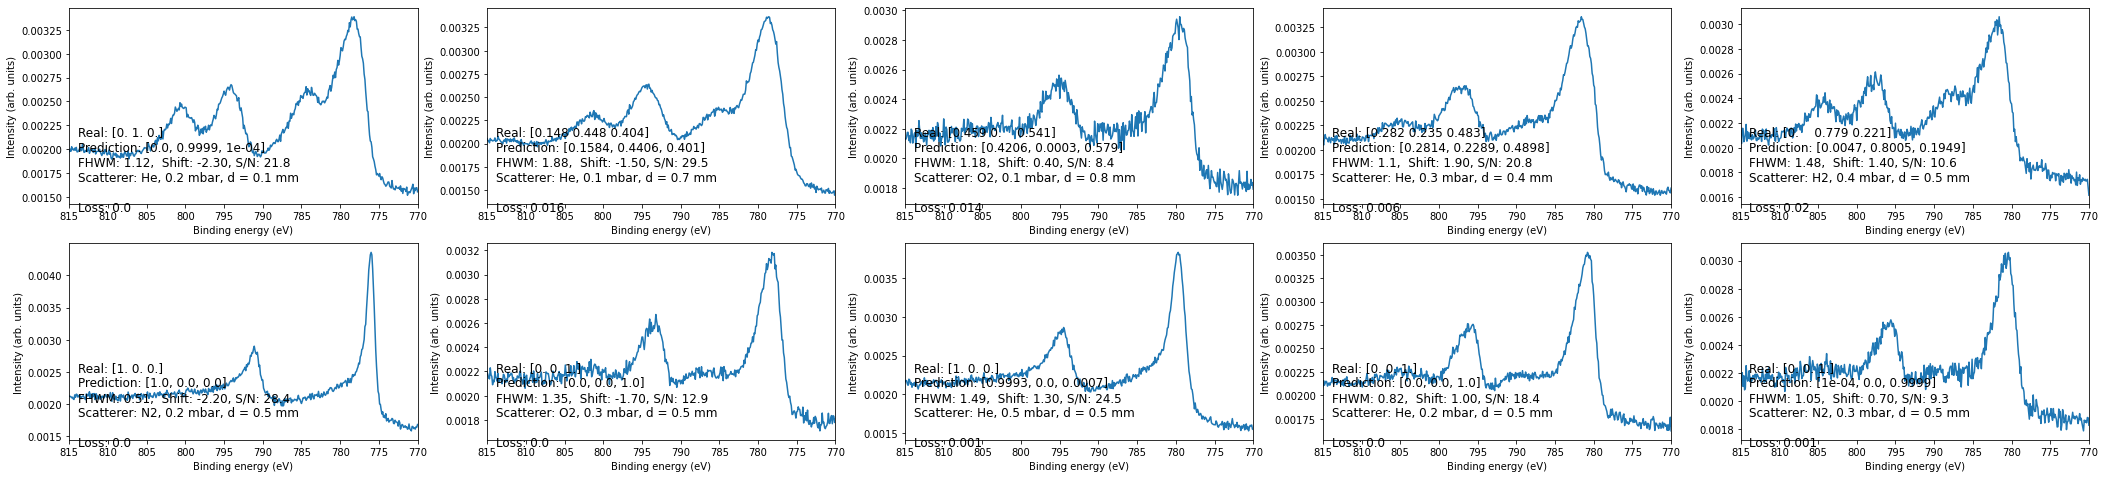

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = "test", with_prediction = True)  

### Show wrong/worst predictions

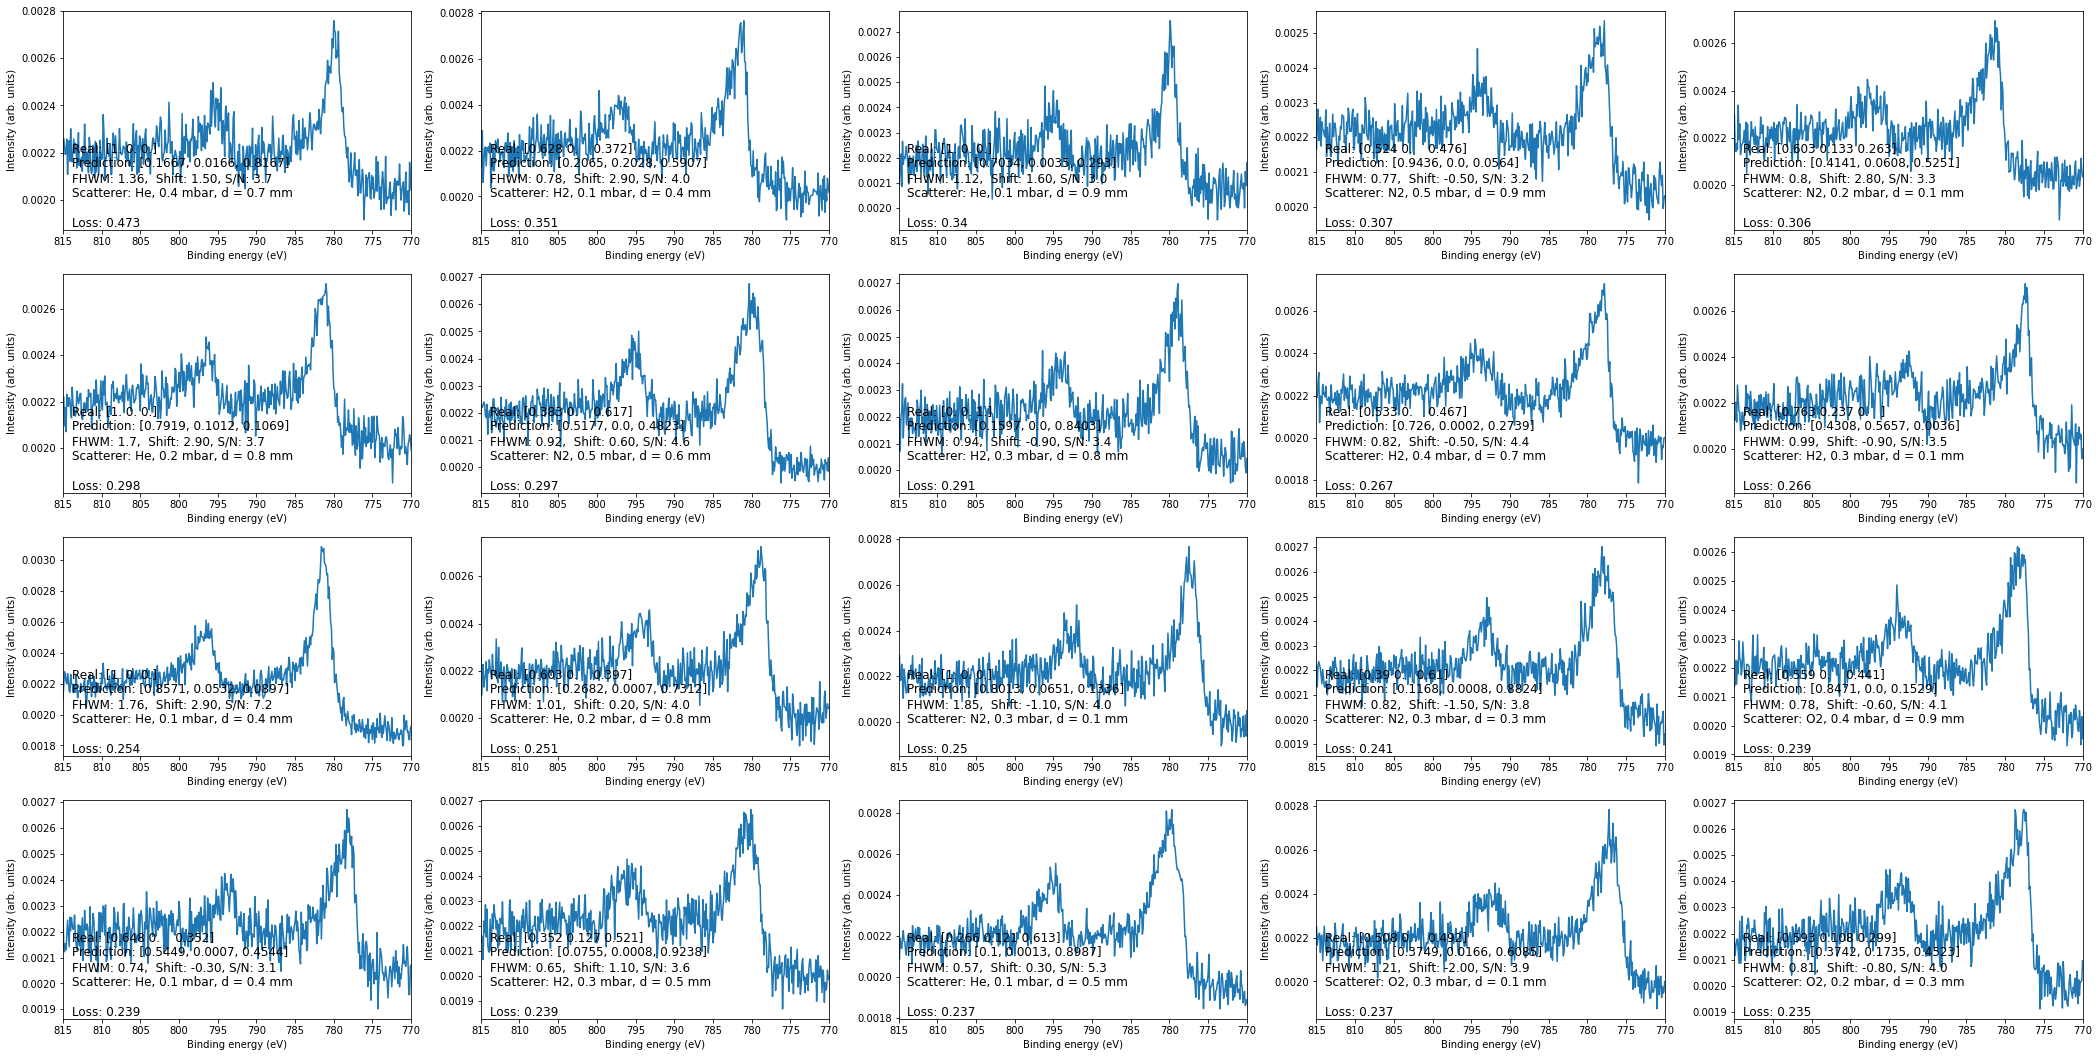

In [ ]:
if clf.task == 'classification':
    clf.show_wrong_classification()
else:
    clf.show_worst_predictions(no_of_spectra = 20)  

### Save model and data

In [ ]:
#clf.save_model()
clf.pickle_results()

Saved results to file.


### Generate report

In [ ]:
dir_name = clf.time + '_' + clf.exp_name
rep = clfutils.Report(dir_name)  
rep.write()

Report saved!


## Prepare website upload

In [ ]:
from xpsdeeplearning.network.prepare_upload import Uploader

dataset_path = clf.logging.hyperparams["input_filepath"].rsplit(".",1)[0] + "_metadata.json"
uploader = Uploader(clf.logging.root_dir, dataset_path)
uploader.prepare_upload_params()
uploader.save_upload_params()

JSON file was prepared for upload!


## Save output of notebook

In [9]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time
import os

time.sleep(20)
save_notebook()
print('Notebook saved!')
time.sleep(30)
current_file = '/content/drive/My Drive/deepxps/xpsdeeplearning/notebooks/train.ipynb'
output_file = os.path.join(clf.logging.log_dir,'train_out.html')
output_HTML(current_file, output_file)
print('HTML file saved!')

Notebook saved!
HTML file saved!
